# Project 4 Feature Engineering, Modeling

DSI-NYC-4: Spring 2018

Team:
>Saqib Nizami

>Carol Duan

>Joe Dorfman

>Vivienne Hay

In [196]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import svm
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, auc, roc_curve, recall_score, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from imblearn.ensemble import BalancedBaggingClassifier, EasyEnsemble
from scipy import stats
import seaborn as sns
import tensorflow as tf
from datetime import datetime
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
import pickle
from yellowbrick.features.importances import FeatureImportances

In [52]:
sns.set_style('dark',{'axes.facecolor': '#EAEAF2',
                      'axes.edgecolor': 'white',
                      'axes.grid': True,
                      'axes.axisbelow': True,
                      'axes.linewidth': 1.0,
                      'axes.labelcolor': 'white'} )
sns.despine()
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

sns.set_palette(flatui)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})


<Figure size 2160x720 with 0 Axes>

In [46]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

---

### Load Data & EDA

In [210]:
df = pd.read_csv('train.csv')
weather = pd.read_csv('weather.csv')
spray = pd.read_csv('spray.csv')
test = pd.read_csv('test.csv')

In [211]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

Magic Load EDA information function

In [208]:
# %load /Users/saqibnizami/notebooks/commonfuncs/edainfo.py
def datainfo(df):
    import re
    '''
    A function to print out routine EDA:
    1. Prints out the shape of the dataframe
    2. Prints column types
    3. Checks for  null values, returns number of nulls
    4. Does something look like a date
    '''
    print('DATASET INFO','\n',
          '-'*10,
          f'\n\n1. Data Shape: {df.shape}', 
          f'\n\n2. Data Types: \n{df.dtypes}', 
          f'\n\n3. Data Head: \n{df.head()}',
          f'\n\n4. Description: \n{df.describe()}',
        )
    
    # null checker
    if df.isnull().sum().sum():
        print(f'\n\n4. There are {df.isnull().sum().sum()} null values : \n', 
              df.isnull().sum())
    elif df.isna().sum().sum():
        print(f'\n\n4. There are {df.isna().sum().sum()} null values : \n', 
              df.isna().sum()) 
    else:
        print('\n\n4. No null values')
        
    # identify the object and numerical columns    
    objectcols = []
    numcols = []
    for name, col in df.iteritems():
        if col.dtype == 'object':
            objectcols.append(name)
        elif col.dtype == 'int' or col.dtype == 'float':
            numcols.append(name)
    
    
    # is there anything that looks like a date in the object columns?
    dateregex = r'^\d{4}-\d{2}-\d{2}'
    for x in objectcols:
        matches = df[x].str.contains(dateregex).value_counts()
        if matches.index.values:
            print(f'\n\n5. The object type column {x} might contain dates')
            
#     # are numeric columns improperly typed?
#     for x in df:
#         matches = df[x].str.contains(r'\d').value_counts()
#         print(matches)
# #         if matches
# #             print(f'\n\n5. The object type column {x} might be numerical')
    
    print('\n\n5. Object and Numerical Columns: \n')    
    return objectcols, numcols    

In [213]:
datainfo(df)

DATASET INFO 
 ---------- 

1. Data Shape: (10506, 12) 

2. Data Types: 
Date                       object
Address                    object
Species                    object
Block                       int64
Street                     object
Trap                       object
AddressNumberAndStreet     object
Latitude                  float64
Longitude                 float64
AddressAccuracy             int64
NumMosquitos                int64
WnvPresent                  int64
dtype: object 

3. Data Head: 
         Date                                            Address  \
0  2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1  2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2  2007-05-29  6200 North Mandell Avenue, Chicago, IL 60646, USA   
3  2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   
4  2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RES

(['Date', 'Address', 'Species', 'Street', 'Trap', 'AddressNumberAndStreet'],
 ['Block',
  'Latitude',
  'Longitude',
  'AddressAccuracy',
  'NumMosquitos',
  'WnvPresent'])

#### Data munging functions

In [5]:
def clean_train_data(df):
    
    # map df dataset with weather dataset
    mask3 = np.power((df['Latitude']-41.995),2)+ np.power((df['Longitude']-(-87.933)),2) <= \
            np.power((df['Latitude']-41.786),2)+ np.power((df['Longitude']-(-87.752)),2)
    mask4 = np.power((df['Latitude']-41.995),2)+ np.power((df['Longitude']-(-87.933)),2) > \
            np.power((df['Latitude']-41.786),2)+ np.power((df['Longitude']-(-87.752)),2)
    df.loc[mask3,'weather_station'] = 1
    df.loc[mask4,'weather_station'] = 2
    df_weather = df.join(weather.set_index(['Date','Station']), on=(['Date','weather_station']), how='left')
    
    # map df_weather dataset with spray dataset
    date_format = "%Y-%m-%d"
    date_formated_df = []
    date_formated_spray = []
    for i in df_weather['Date']:
        date_formated_df.append(datetime.strptime(i, date_format))
    for i in spray['Date']:
        date_formated_spray.append(datetime.strptime(i, date_format))
    date_formated_spray = set(date_formated_spray)
    date_formated_spray = list(date_formated_spray)
    days_after_spray = []
    for i in date_formated_df:
        delta = []
        for n in date_formated_spray:
            if (i - n).days > 0:
                delta.append((i - n).days)
        if len(delta) != 0:
            days = np.min(delta)
        else:
            days = 0
        days_after_spray.append(days)
    df_weather['days_after_spray'] = days_after_spray

    ## deal with the missing value of the useful columns
    mask5 = (df_weather.PrecipTotal == '  T')| (df_weather.PrecipTotal =='M')
    mask6 = df_weather.WetBulb == 'M'
    mask7 = df_weather.StnPressure == 'M'
    df_weather.loc[mask5,'PrecipTotal'] = 0.00
    df_weather.loc[mask6,'WetBulb'] = round((df_weather[df_weather.WetBulb!='M']['WetBulb']).astype('int').mean())
    df_weather.loc[mask7,'StnPressure'] = round((df_weather[df_weather.StnPressure!='M']['StnPressure']).astype('float').mean(),2)
    
    #create columns for light and heavy rain day off and within 14 days 
    df_weather['PrecipTotal'] = df_weather['PrecipTotal'].astype(float)
    precip_75quantile = df_weather[df_weather['PrecipTotal'] > 0]['PrecipTotal'].quantile(.75)
    precip_25quantile = df_weather[df_weather['PrecipTotal'] > 0]['PrecipTotal'].quantile(.25)

    df_weather['heavy_rain'] = (df_weather['PrecipTotal']>precip_75quantile).astype(int)
    df_weather['light_rain'] = ((df_weather['PrecipTotal']>0) & (df_weather['PrecipTotal']<precip_25quantile)).astype(int)

    for i in range(1,15):
        df_weather['light_rain_past' + str(i)] = df_weather['light_rain'].shift(periods=i)
        df_weather['heavy_rain_past' + str(i)] = df_weather['heavy_rain'].shift(periods=i)
    
    #create column if it rained in the past 14 days 
    df_weather['heavy_rain_last_14_days'] = np.where(df_weather[['heavy_rain_past1', 'heavy_rain_past2',
       'heavy_rain_past3', 'heavy_rain_past4', 'heavy_rain_past5',
       'heavy_rain_past6', 'heavy_rain_past7', 'heavy_rain_past8',
       'heavy_rain_past9', 'heavy_rain_past10', 'heavy_rain_past11',
       'heavy_rain_past12', 'heavy_rain_past13', 'heavy_rain_past14']].any(axis=1), 1, 0)

    df_weather['light_reain_last_14_days'] = np.where(df_weather[['light_rain_past1', 'light_rain_past2',
       'light_rain_past3', 'light_rain_past4', 'light_rain_past5',
       'light_rain_past6', 'light_rain_past7', 'light_rain_past8',
       'light_rain_past9', 'light_rain_past10', 'light_rain_past11',
       'light_rain_past12', 'light_rain_past13', 'light_rain_past14',]].any(axis=1), 1, 0)
    
    # clean up the total dataset 
    df_total = df_weather
    
    #fix NumMosquitos column
    df_total['NumMosquitos_sum'] = np.nan #create sum column
    #fill sum column with sum of matching rows
    df_total['NumMosquitos_sum'].fillna(df_total.groupby(['Date','Trap','Species'])['NumMosquitos'].transform('sum'), inplace=True)
    df_total.drop(['NumMosquitos'], axis=1, inplace=True) #drop old column
    df_total.drop_duplicates(inplace=True) #drop duplicated rows 
    df_total.reset_index(inplace=True) #reset index 
    
    #create ordinal date column
    df_total['Date'] = pd.to_datetime(df_total['Date'])
    df_total['ordinal_date'] = df_total['Date'].map(lambda x: x.toordinal())
    
    #create month/day for time of year 
    df_total['month_day'] = df_total['Date'].dt.month + df_total['Date'].map(lambda x: .5 if x.day > 15 else 0)
    
    ## drop useless columns
    ## different for train and test dataset because test data doesn't include 'NumMosquitos' column
    ## and test data has "Id" column that need to be dropped
    
    df_total = df_total.drop(['Date','Address','Block','Street','Trap','AddressNumberAndStreet',\
              'AddressAccuracy','weather_station','Depart','CodeSum','Depth',\
              'Water1','SnowFall', 'Sunrise', 'Sunset', 'index'],axis=1)
              # NumMosquitos and CodeSum may still helpful (test data doesn't include 'NumMosquitos' column)
              #**changed this to keep NumMosquitos
    
    ## change the datatype to correct one
    df_total[['Tavg','WetBulb','Heat','Cool']] = df_total[['Tavg','WetBulb','Heat','Cool']].astype(int)
    df_total[['PrecipTotal','StnPressure','SeaLevel','AvgSpeed']] = \
    df_total[['PrecipTotal','StnPressure','SeaLevel','AvgSpeed']].astype(float)
    
    #computer rolling averages 
    for i in [3,5,10,14,21,30]: #set intervals for rolling average calculation
        for j in ['Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Heat', 'Cool',    #columns to compute rolling averages for
                  'PrecipTotal', 'StnPressure', 'SeaLevel','ResultSpeed', 'ResultDir', 'AvgSpeed']:
            df_total[j + str(i)] = df_total[j].rolling(window=i, min_periods=int(i/5)).mean() #create column with interval for each computation
                                                                                #min_periods allows for computing these and not getting NaN values
                                                                                #for reasonable amount of missing data
    ## dummy the object variable
    df_total = pd.get_dummies(df_total,drop_first=True,columns=['Species', 'month_day'])
    
    #drop'month_day_6.0', not in test data 
    df_total.drop(['month_day_6.0'], axis=1, inplace=True)
    
    #fill na's
    df_total.fillna(method='backfill', inplace=True)
    
    
    # return cleaned dataframe

    return df_total

In [6]:
def clean_test_data(df):
    
    # map df dataset with weather dataset
    mask3 = np.power((df['Latitude']-41.995),2)+ np.power((df['Longitude']-(-87.933)),2) <= \
            np.power((df['Latitude']-41.786),2)+ np.power((df['Longitude']-(-87.752)),2)
    mask4 = np.power((df['Latitude']-41.995),2)+ np.power((df['Longitude']-(-87.933)),2) > \
            np.power((df['Latitude']-41.786),2)+ np.power((df['Longitude']-(-87.752)),2)
    df.loc[mask3,'weather_station'] = 1
    df.loc[mask4,'weather_station'] = 2
    df_weather = df.join(weather.set_index(['Date','Station']), on=(['Date','weather_station']), how='left')

    # map df_weather dataset with spray dataset
    date_format = "%Y-%m-%d"
    date_formated_df = []
    date_formated_spray = []
    for i in df_weather['Date']:
        date_formated_df.append(datetime.strptime(i, date_format))
    for i in spray['Date']:
        date_formated_spray.append(datetime.strptime(i, date_format))
    date_formated_spray = set(date_formated_spray)
    date_formated_spray = list(date_formated_spray)
    days_after_spray = []
    for i in date_formated_df:
        delta = []
        for n in date_formated_spray:
            if (i - n).days > 0:
                delta.append((i - n).days)
        if len(delta) != 0:
            days = np.min(delta)
        else:
            days = 0
        days_after_spray.append(days)
    df_weather['days_after_spray'] = days_after_spray
    
    ## deal with the missing value of the useful columns
    mask5 = (df_weather.PrecipTotal == '  T')| (df_weather.PrecipTotal =='M')
    mask6 = df_weather.WetBulb == 'M'
    mask7 = df_weather.StnPressure == 'M'
    df_weather.loc[mask5,'PrecipTotal'] = 0.00
    df_weather.loc[mask6,'WetBulb'] = round((df_weather[df_weather.WetBulb!='M']['WetBulb']).astype('int').mean())
    df_weather.loc[mask7,'StnPressure'] = round((df_weather[df_weather.StnPressure!='M']['StnPressure']).astype('float').mean(),2)
    
    #create columns for light and heavy rain day off and within 14 days 
    df_weather['PrecipTotal'] = df_weather['PrecipTotal'].astype(float)
    precip_75quantile = df_weather[df_weather['PrecipTotal'] > 0]['PrecipTotal'].quantile(.75)
    precip_25quantile = df_weather[df_weather['PrecipTotal'] > 0]['PrecipTotal'].quantile(.25)

    df_weather['heavy_rain'] = (df_weather['PrecipTotal']>precip_75quantile).astype(int)
    df_weather['light_rain'] = ((df_weather['PrecipTotal']>0) & (df_weather['PrecipTotal']<precip_25quantile)).astype(int)

    for i in range(1,15):
        df_weather['light_rain_past' + str(i)] = df_weather['light_rain'].shift(periods=i)
        df_weather['heavy_rain_past' + str(i)] = df_weather['heavy_rain'].shift(periods=i)
    
    #create column if it rained in the past 14 days 
    df_weather['heavy_rain_last_14_days'] = np.where(df_weather[['heavy_rain_past1', 'heavy_rain_past2',
       'heavy_rain_past3', 'heavy_rain_past4', 'heavy_rain_past5',
       'heavy_rain_past6', 'heavy_rain_past7', 'heavy_rain_past8',
       'heavy_rain_past9', 'heavy_rain_past10', 'heavy_rain_past11',
       'heavy_rain_past12', 'heavy_rain_past13', 'heavy_rain_past14']].any(axis=1), 1, 0)

    df_weather['light_reain_last_14_days'] = np.where(df_weather[['light_rain_past1', 'light_rain_past2',
       'light_rain_past3', 'light_rain_past4', 'light_rain_past5',
       'light_rain_past6', 'light_rain_past7', 'light_rain_past8',
       'light_rain_past9', 'light_rain_past10', 'light_rain_past11',
       'light_rain_past12', 'light_rain_past13', 'light_rain_past14',]].any(axis=1), 1, 0)
    
    # clean up the total dataset 
    df_total = df_weather
    
    #create ordinal date column
    df_total['Date'] = pd.to_datetime(df_total['Date'])
    df_total['ordinal_date'] = df_total['Date'].map(lambda x: x.toordinal())
    
    #create month/day for time of year 
    df_total['month_day'] = df_total['Date'].dt.month + df_total['Date'].map(lambda x: .5 if x.day > 15 else 0)
    
    ## drop useless columns
    ## different for train and test dataset because test data doesn't include 'NumMosquitos' column
    ## and test data has "Id" column that need to be dropped
    
    ### for train dataset
#     df_total = df_total.drop(['Date','Address','Block','Street','Trap','AddressNumberAndStreet',\
#               'AddressAccuracy','weather_station','Depart','CodeSum','Depth',\
#               'Water1','SnowFall','Sunrise','Sunset','NumMosquitos'],axis=1)
                 
                 # NumMosquitos and CodeSum may still helpful (test data doesn't include 'NumMosquitos' column)
    
    ### for test dataset
    df_total = df_total.drop(['Id','Date','Address','Block','Street','Trap','AddressNumberAndStreet',\
               'AddressAccuracy','weather_station','Depart','CodeSum','Depth',\
               'Water1','SnowFall','Sunrise','Sunset'],axis=1)
    
    
    ## change the datatype to correct one
    df_total[['Tavg','WetBulb','Heat','Cool']] = df_total[['Tavg','WetBulb','Heat','Cool']].astype(int)
    df_total[['PrecipTotal','StnPressure','SeaLevel','AvgSpeed']] = \
    df_total[['PrecipTotal','StnPressure','SeaLevel','AvgSpeed']].astype(float)
    
    #computer rolling averages 
    for i in [3,5,10,14,21,30]: #set intervals for rolling average calculation
        for j in ['Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Heat', 'Cool',    #columns to compute rolling averages for
                  'PrecipTotal', 'StnPressure', 'SeaLevel','ResultSpeed', 'ResultDir', 'AvgSpeed']:
            df_total[j + str(i)] = df_total[j].rolling(window=i, min_periods=int(i/5)).mean() #create column with interval for each computation
                                                                                #min_periods allows for computing these and not getting NaN values
                                                                                #for reasonable amount of missing data
    #fill na's
    df_total.fillna(method='backfill', inplace=True)

    ## dummy the object variable
    df_total = pd.get_dummies(df_total,drop_first=True,columns=['Species', 'month_day'])
    
    
    ## drop one of the dummy variable 'Species_UNSPECIFIED CULEX' that train dataset doesn't have
    df_total = df_total.drop(['Species_UNSPECIFIED CULEX'],axis=1)
    
    # create polynomial features
    
    ## for train dataset
#     y = df_total['WnvPresent']
#     X = df_total.drop('WnvPresent',axis=1)
#     X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.15)
#     poly = PolynomialFeatures(include_bias=False,degree=2)
#     X_train_poly = poly.fit_transform(X_train)
#     X_test_poly = poly.transform(X_test)
#     X_train=pd.DataFrame(X_train_poly,columns=poly.get_feature_names(X_train.columns))
#     X_test=pd.DataFrame(X_test_poly,columns=poly.get_feature_names(X_test.columns))
    
    ## for test dataset
#     poly = PolynomialFeatures(include_bias=False,degree=2)
#     df_total_poly = poly.fit_transform(df_total)
#     df_total=pd.DataFrame(df_total_poly,columns=poly.get_feature_names(df_total.columns))
    
    # return cleaned dataframe
    
    ## for train dataset, return X_train and X_test data
#     return X_train, X_test
    
    ## for test dataset, return df_total
    return df_total

In [7]:
test_clean = clean_test_data(test)
test_clean.shape

(116293, 141)

In [8]:
train_clean = clean_train_data(df)
train_clean.shape

(8803, 143)

#### Feature Engineering: Relative Humidity

In [9]:
def humidity(Tf, Tdf):

    # convert temp to celsius
    Tc=5.0/9.0*(Tf-32.0)
    # convert dewpoint temp to celsius
    Tdc=5.0/9.0*(Tdf-32.0)
    # saturation vapor pressure
    Es=6.11*10.0**(7.5*Tc/(237.7+Tc))
    # actual vapor pressure
    E=6.11*10.0**(7.5*Tdc/(237.7+Tdc))
    #relative humidity
    RH =(E/Es)*100
        
    return RH

train_clean["RelHum"] = humidity(train_clean['Tavg'],train_clean['DewPoint'])
test_clean["RelHum"] = humidity(test_clean['Tavg'],test_clean['DewPoint'])

In [11]:
assert [cols for cols in train_clean.columns if cols not in test_clean.columns] == ['WnvPresent', 'NumMosquitos_sum']

In [214]:
[cols for cols in train_clean.columns if cols not in test_clean.columns]

['WnvPresent', 'NumMosquitos_sum']

In [12]:
train_clean['WnvPresent'].value_counts(normalize=True)

0    0.946723
1    0.053277
Name: WnvPresent, dtype: float64

---

### Model 1: Mosquito Regression

In [191]:
#create x and y columns for num mosquitos; take log of nummosquitos
col_list = ['NumMosquitos_sum', 'WnvPresent']
X_mos = train_clean[[cols for cols in train_clean.columns if cols not in col_list]]
# y_mos = np.log(train_clean['NumMosquitos_sum'])
y_mos = train_clean['NumMosquitos_sum']

#TTS
X_train_mos, X_test_mos, y_train_mos, y_test_mos = train_test_split(X_mos, y_mos, random_state=40, test_size=0.15)

In [17]:
pip_xgb = Pipeline([
    ('ss', StandardScaler()),
    ('xgb', xgb.XGBRegressor(reg_lambda=0))
    
])

params_xgb = {
    'xgb__n_estimators':[125,150, 175],
    'xgb__learning_rate': [.1, .15, .2],
    'xgb__max_depth': [3,5,7],
    'xgb__reg_lambda': [0,1],
    'xgb__reg_alpha': [0,1]
}
gs2 = GridSearchCV(pip_xgb,param_grid=params_xgb)
gs2.fit(X_train_mos,y_train_mos)
print('best cv score', gs2.best_score_)
print('best paramas', gs2.best_params_)
print('test score', gs2.score(X_test_mos, y_test_mos))

KeyboardInterrupt: 

In [ ]:
#plot predictions vs actual on test set 
test_predictions_mos = np.exp(gs2.predict(X_test_mos))
sns.jointplot(test_predictions_mos, y_test_mos, kind='reg', data= train_clean, size=10);

In [ ]:
#fit model on all training data
mos_model = gs2.best_estimator_
mos_model.fit(X_mos, y_mos)

In [ ]:
#predict mosquito counts for test data
test_clean['project_mos'] = np.exp(mos_model.predict(test_clean))

In [ ]:
test_clean['project_mos'].plot()

In [ ]:
#predict mosquito counts for train data 
train_predicitions = np.exp(mos_model.predict(X_mos))
train_clean['project_mos'] = train_predicitions

Adventures in pickling

In [ ]:
#pickle/unpickle model below and make predicitions
# modelfilename= 'mos_model.sav'
# pickle.dump(mos_model, open(modelfilename, 'wb'))

# loaded_model = pickle.load(open('mos_model2.sav', 'rb'))

# loaded_model.score(X_test_mos, y_test_mos)

# #predict mosquito counts for test data
# test_clean['project_mos'] = loaded_model.predict(test_clean)

# #predict mosquito counts for train data 
# train_clean['project_mos'] = loaded_model.predict(train_clean)

---

### Carol's Upsampling Technique

In [ ]:
from sklearn.utils import resample

## Separate majority and minority classes
df_majority = train_clean[train_clean.WnvPresent==0]
df_minority = train_clean[train_clean.WnvPresent==1]
 
## Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=8334,    # to match majority class
                                 random_state=42) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.WnvPresent.value_counts()

In [ ]:
y = df_upsampled['WnvPresent']
X = df_upsampled.drop(['WnvPresent', 'NumMosquitos_sum'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.15)

---

---

### XCBoostClassifier: HYPER-PARAMETER Tuning

Generalized Initial Approach to Parameter Tuning for XGBoost:
1. High learning rate: somewhere between 0.05 to 0.3.
    Use XGBoost's cv to cross validate and return the optimum number of trees needed
2. Tune tree parameters: max_depth, min_child_weight, gamma, subsample, colsample_bytree for the learning rate and tree number.
3. Tune regularization params: lambda and alpha to reduce model complexity
4. Lower the learning rate and decide the optimal parameters

In [48]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = (30, 10)

In [65]:
test_clean.columns, train_clean[predictors].columns

(Index(['Latitude', 'Longitude', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb',
        'Heat', 'Cool', 'PrecipTotal',
        ...
        'Species_CULEX TERRITANS', 'month_day_6.5', 'month_day_7.0',
        'month_day_7.5', 'month_day_8.0', 'month_day_8.5', 'month_day_9.0',
        'month_day_9.5', 'month_day_10.0', 'RelHum'],
       dtype='object', length=142),
 Index(['Latitude', 'Longitude', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb',
        'Heat', 'Cool', 'PrecipTotal',
        ...
        'Species_CULEX TERRITANS', 'month_day_6.5', 'month_day_7.0',
        'month_day_7.5', 'month_day_8.0', 'month_day_8.5', 'month_day_9.0',
        'month_day_9.5', 'month_day_10.0', 'RelHum'],
       dtype='object', length=142))

In [66]:
# trainf = train_clean.drop(columns=['WnvPresent','NumMosquitos'])
trainf = train_clean.drop(columns=['WnvPresent', 'NumMosquitos_sum'])
predictors = list(trainf.columns.values)
target = 'WnvPresent'

In [105]:
# 
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds, metrics='auc', 
                          early_stopping_rounds=early_stopping_rounds, verbose_eval=True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['WnvPresent'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print( "\nModel Report")
    print( "Accuracy : %.4g" % accuracy_score(dtrain['WnvPresent'].values, dtrain_predictions))
    print( "AUC Score (Train): %f" % roc_auc_score(dtrain['WnvPresent'], dtrain_predprob))
    print(cvresult)
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)[:50]
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

The modelfit function will show important features for our data as we tune the model.

In [104]:
xgb1.learning_rate

0.1

In [64]:
pd.Series(xgb1.get_booster().get_fscore()).sort_values(ascending=False)[:50]

f1      151
f0      105
f48      81
f124     32
f115     32
f111     28
f125     24
f112     24
f114     24
f127     23
f137     22
f108     21
f129     20
f101     20
f126     19
f86      18
f69      17
f102     16
f122     16
f85      16
f128     15
f75      15
f113     14
f15      14
f98      14
f99      14
f88      13
f49      13
f87      13
f117     13
f121     13
f83      13
f109     12
f60      12
f100     12
f90      11
f10      11
f141     11
f76      11
f72      11
f104     11
f95      11
f132     10
f136     10
f2       10
f77       9
f12       9
f57       9
f133      9
f138      9
dtype: int64

Set the learning rate and number of estimators for the tree based parameters

[0]	train-auc:0.778574+0.0046976	test-auc:0.751585+0.0127643
[1]	train-auc:0.826701+0.0058161	test-auc:0.788851+0.0103352
[2]	train-auc:0.84445+0.00659434	test-auc:0.796939+0.0137163
[3]	train-auc:0.851841+0.00607283	test-auc:0.801262+0.0174134
[4]	train-auc:0.862417+0.00473524	test-auc:0.811512+0.00861012
[5]	train-auc:0.864742+0.00469507	test-auc:0.815189+0.0115154
[6]	train-auc:0.869222+0.00523161	test-auc:0.816679+0.0123894
[7]	train-auc:0.870816+0.00364505	test-auc:0.816487+0.0130463
[8]	train-auc:0.876601+0.00232252	test-auc:0.820541+0.0153471
[9]	train-auc:0.879826+0.00245644	test-auc:0.824085+0.0135506
[10]	train-auc:0.882088+0.00245112	test-auc:0.823439+0.0134024
[11]	train-auc:0.883707+0.00214582	test-auc:0.823324+0.0125432
[12]	train-auc:0.888567+0.00251745	test-auc:0.827871+0.0130038
[13]	train-auc:0.890721+0.00295344	test-auc:0.827438+0.0124783
[14]	train-auc:0.893076+0.00206694	test-auc:0.828063+0.0108548
[15]	train-auc:0.895378+0.00261402	test-auc:0.827282+0.0112773
[16]

/Users/saqibnizami/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9519
AUC Score (Train): 0.932598
    test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0        0.751585      0.012764        0.778574       0.004698
1        0.788851      0.010335        0.826701       0.005816
2        0.796939      0.013716        0.844450       0.006594
3        0.801262      0.017413        0.851841       0.006073
4        0.811512      0.008610        0.862417       0.004735
5        0.815189      0.011515        0.864742       0.004695
6        0.816679      0.012389        0.869222       0.005232
7        0.816487      0.013046        0.870816       0.003645
8        0.820541      0.015347        0.876601       0.002323
9        0.824085      0.013551        0.879826       0.002456
10       0.823439      0.013402        0.882088       0.002451
11       0.823324      0.012543        0.883707       0.002146
12       0.827871      0.013004        0.888567       0.002517
13       0.827438      0.012478        0.890721       0.00

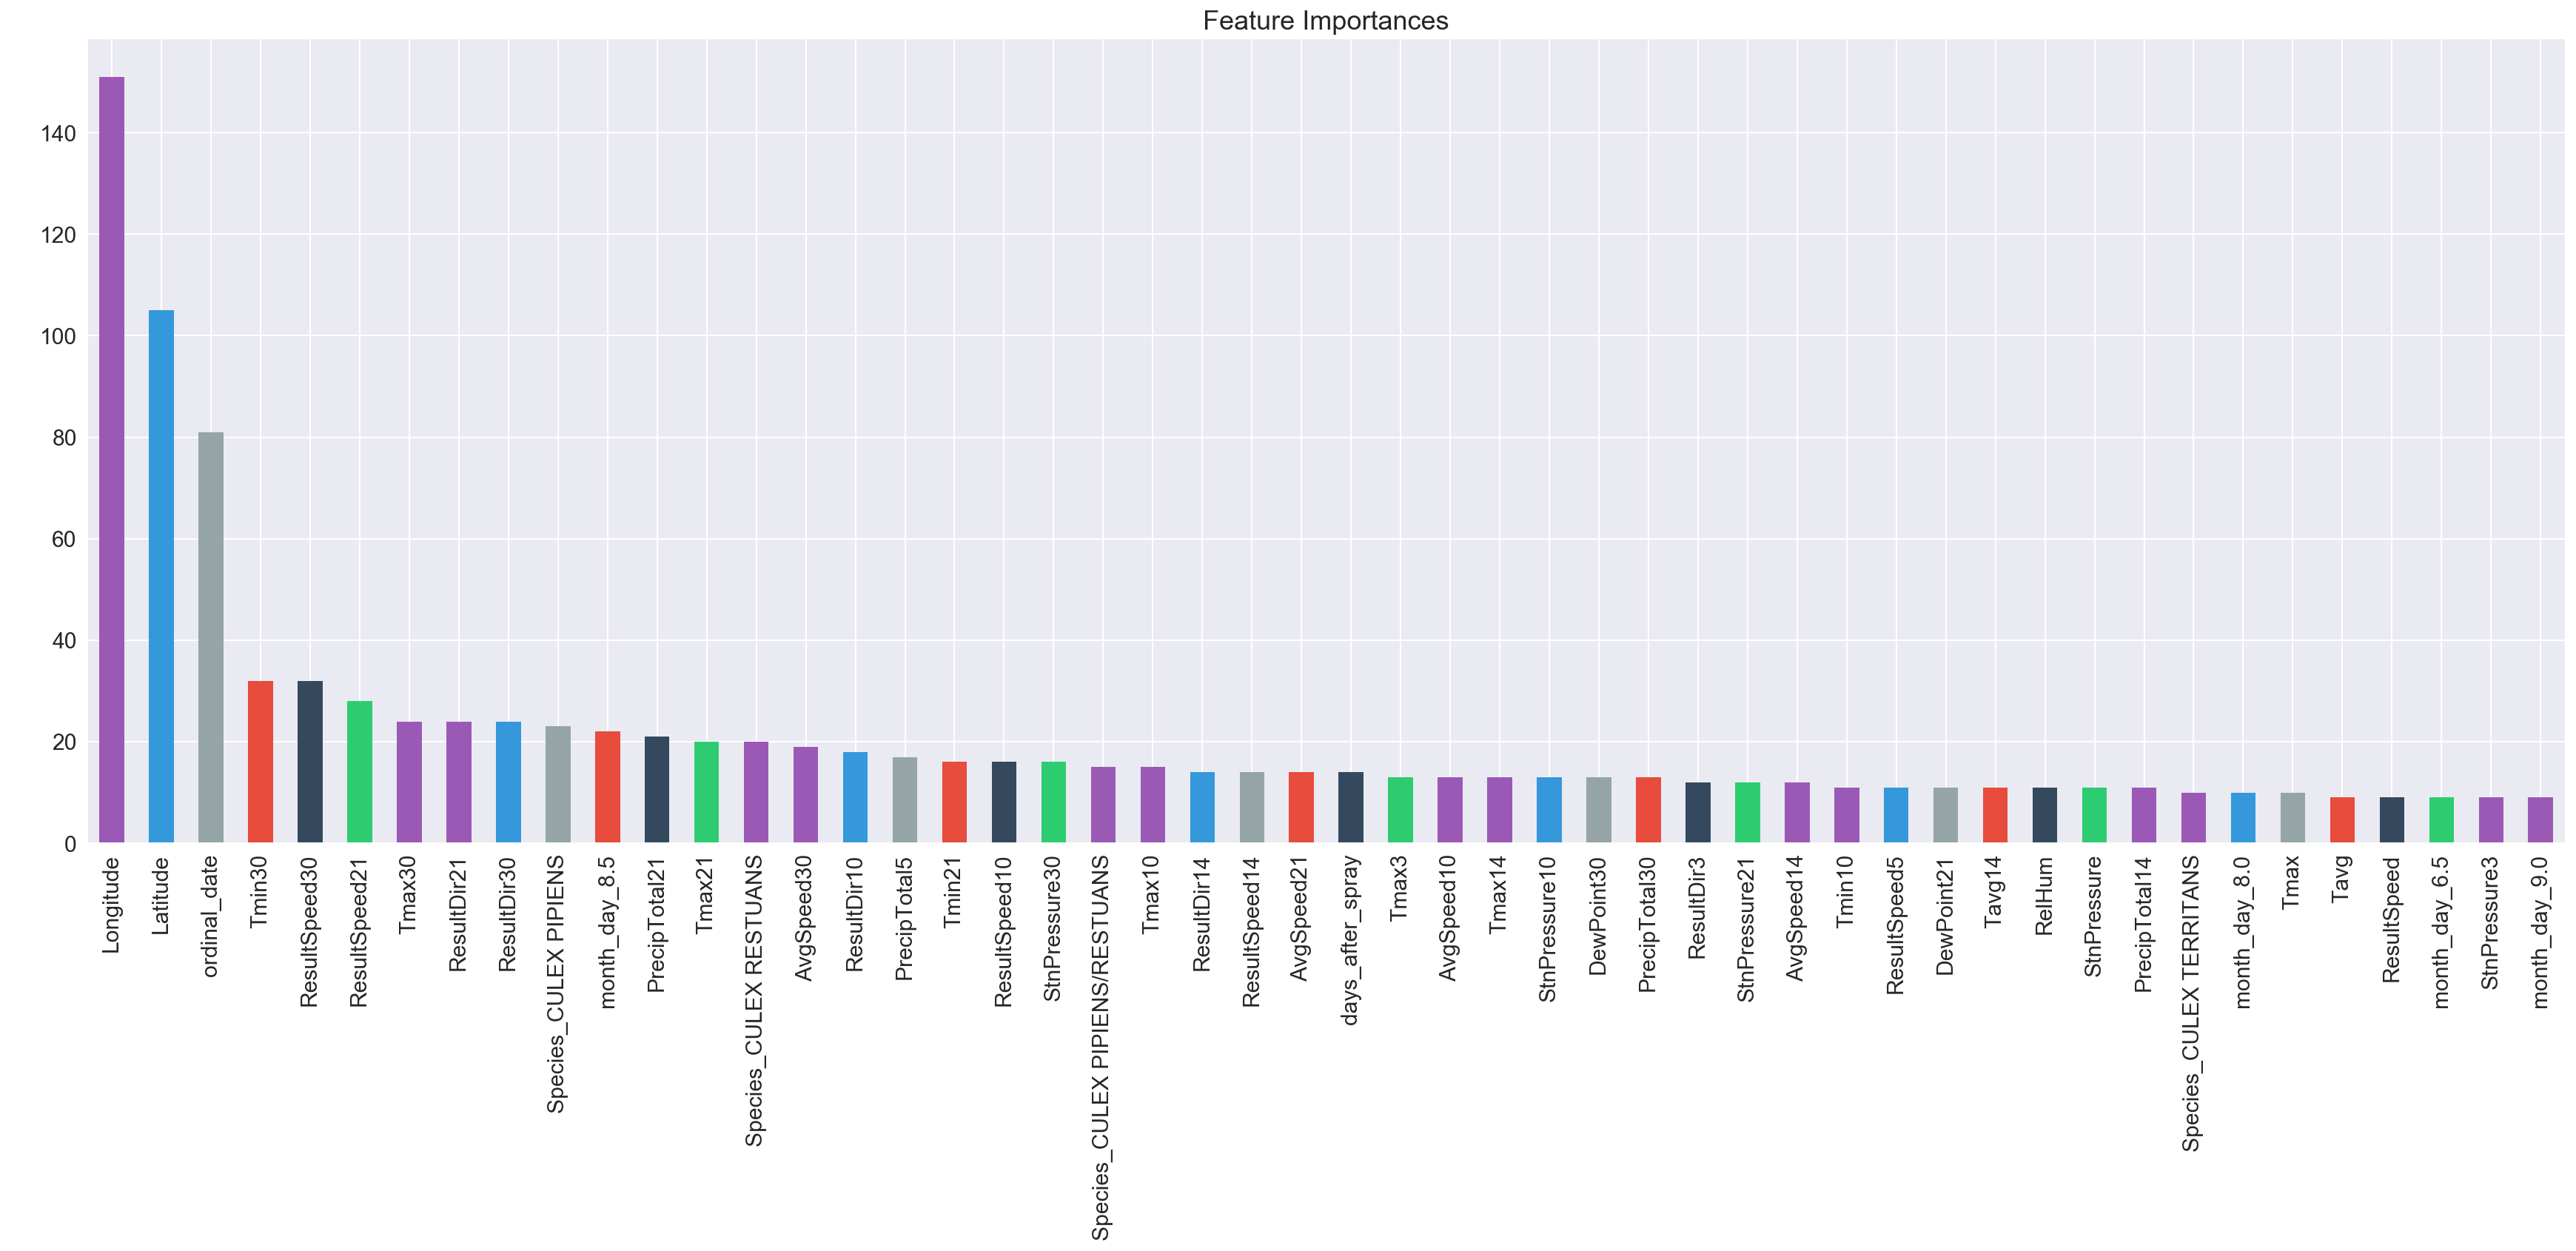

In [106]:
xgb1 = XGBClassifier(learning_rate =0.1, 
                     n_estimators=1000, 
                     max_depth=5, 
                     min_child_weight=1, 
                     gamma=0, 
                     subsample=0.8, 
                     colsample_bytree=0.8, 
                     objective= 'binary:logistic', 
                     nthread=4, scale_pos_weight=1, seed=27)

modelfit(xgb1, train_clean, predictors)

_The top 50 features from this run_

Tuning for max_depth and min_child_weight:

In [107]:
param_test1 = {'max_depth':range(3,10,2),
               'min_child_weight':range(1,6,2)
              }

gs1 = GridSearchCV(estimator= XGBClassifier(learning_rate=0.1,
                                            n_estimators=60,
                                            max_depth=5,
                                            min_child_weight=1,
                                            gamma=0,
                                            subsample=0.8,
                                            colsample_bytree=0.8,
                                            objective='binary:logistic',
                                            nthread=4,
                                            scale_pos_weight=1,
                                            seed=19), 
                   param_grid = param_test1, scoring='roc_auc', n_jobs=2, iid=False, cv=5)

gs1.fit(train_clean[predictors], train_clean[target])
gs1.grid_scores_, gs1.best_params_, gs1.best_score_


/Users/saqibnizami/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.46449, std: 0.20252, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.47970, std: 0.21440, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.47899, std: 0.21657, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.39638, std: 0.17662, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.43968, std: 0.20115, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.41712, std: 0.20294, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.36856, std: 0.17568, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.40381, std: 0.19613, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.40540, std: 0.19832, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.36514, std: 0.18083, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.39247, std: 0.19475, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.38038, std: 0.18495, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 3, 'min_child_weight': 3

Seems like the optimal max_depth and min_child_weight is 3, it is recommended to search values around it though:

In [109]:
param_test2 = {
 'max_depth':[2,3,4],
 'min_child_weight':[2,3,4]
}
gs2 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1,
                                                  n_estimators=60,
                                                  max_depth=3,
                                                  min_child_weight=3,
                                                  gamma=0,
                                                  subsample=0.8,
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic',
                                                  nthread=4,
                                                  scale_pos_weight=1,
                                                  seed=27), 
                        param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gs2.fit(train_clean[predictors],train_clean[target])
gs2.grid_scores_, gs2.best_params_, gs2.best_score_

/Users/saqibnizami/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.52450, std: 0.20899, params: {'max_depth': 2, 'min_child_weight': 2},
  mean: 0.53691, std: 0.21758, params: {'max_depth': 2, 'min_child_weight': 3},
  mean: 0.52747, std: 0.22034, params: {'max_depth': 2, 'min_child_weight': 4},
  mean: 0.45331, std: 0.19955, params: {'max_depth': 3, 'min_child_weight': 2},
  mean: 0.48420, std: 0.21811, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.48745, std: 0.22493, params: {'max_depth': 3, 'min_child_weight': 4},
  mean: 0.43005, std: 0.19285, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: 0.42634, std: 0.19398, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: 0.45344, std: 0.21615, params: {'max_depth': 4, 'min_child_weight': 4}],
 {'max_depth': 2, 'min_child_weight': 3},
 0.5369121487814927)

Model performance has increased, and max_depth is now 2 and min_child_weight is 3

Check values for min_child_weight above 3:

In [111]:
param_test2b = {'min_child_weight':[3,4,5,6,7]}

gs2b = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, 
                                                   n_estimators=60,
                                                   max_depth=2,
                                                   min_child_weight=3,
                                                   gamma=0,
                                                   subsample=0.8,
                                                   colsample_bytree=0.8,
                                                   objective= 'binary:logistic',
                                                   nthread=4,
                                                   scale_pos_weight=1,
                                                   seed=27),
                         param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gs2b.fit(train_clean[predictors],train_clean[target])
gs2b.grid_scores_, gs2b.best_params_, gs2b.best_score_

/Users/saqibnizami/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.53691, std: 0.21758, params: {'min_child_weight': 3},
  mean: 0.52747, std: 0.22034, params: {'min_child_weight': 4},
  mean: 0.51954, std: 0.22000, params: {'min_child_weight': 5},
  mean: 0.53606, std: 0.20854, params: {'min_child_weight': 6},
  mean: 0.52718, std: 0.22942, params: {'min_child_weight': 7}],
 {'min_child_weight': 3},
 0.5369121487814927)

seems like 3 is the optimal min_child_weight value

Next step is to tune the gamma:

In [112]:
param_test3 = { 'gamma':[i/10.0 for i in range(0,5)]}

gs3 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, 
                                                   n_estimators=60,
                                                   max_depth=2,
                                                   min_child_weight=3,
                                                   gamma=0,
                                                   subsample=0.8,
                                                   colsample_bytree=0.8,
                                                   objective= 'binary:logistic',
                                                   nthread=4,
                                                   scale_pos_weight=1,
                                                   seed=27),
                         param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gs3.fit(train_clean[predictors],train_clean[target])
gs3.grid_scores_, gs3.best_params_, gs3.best_score_

/Users/saqibnizami/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.53691, std: 0.21758, params: {'gamma': 0.0},
  mean: 0.53691, std: 0.21758, params: {'gamma': 0.1},
  mean: 0.53691, std: 0.21758, params: {'gamma': 0.2},
  mean: 0.53683, std: 0.21754, params: {'gamma': 0.3},
  mean: 0.53683, std: 0.21754, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 0.5369121487814927)

gamma of 0 is the optimal one

Instantiate a new XGBC with optimal params and reclaibrated # of boosting rounds

[0]	train-auc:0.701922+0.00469908	test-auc:0.691253+0.0122996
[1]	train-auc:0.746202+0.0183218	test-auc:0.741545+0.0299823
[2]	train-auc:0.757661+0.0228076	test-auc:0.752223+0.029654
[3]	train-auc:0.762308+0.0277754	test-auc:0.752277+0.0320248
[4]	train-auc:0.763492+0.0287366	test-auc:0.754183+0.0345591
[5]	train-auc:0.774261+0.0301062	test-auc:0.765259+0.0362099
[6]	train-auc:0.777144+0.0286659	test-auc:0.767789+0.0349972
[7]	train-auc:0.785725+0.0105252	test-auc:0.770931+0.0255805
[8]	train-auc:0.790212+0.00992477	test-auc:0.77069+0.0260048
[9]	train-auc:0.79443+0.00761581	test-auc:0.775292+0.0256526
[10]	train-auc:0.794963+0.00673521	test-auc:0.775863+0.0250167
[11]	train-auc:0.795894+0.00439567	test-auc:0.777718+0.0214304
[12]	train-auc:0.796819+0.00286518	test-auc:0.781675+0.0196693
[13]	train-auc:0.79961+0.00401988	test-auc:0.784381+0.0211565
[14]	train-auc:0.80236+0.00440794	test-auc:0.784271+0.021359
[15]	train-auc:0.804286+0.00321934	test-auc:0.786476+0.0206392
[16]	train-auc:

/Users/saqibnizami/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.948
AUC Score (Train): 0.898585
     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.691253      0.012300        0.701922       0.004699
1         0.741545      0.029982        0.746202       0.018322
2         0.752223      0.029654        0.757661       0.022808
3         0.752277      0.032025        0.762308       0.027775
4         0.754183      0.034559        0.763492       0.028737
5         0.765259      0.036210        0.774261       0.030106
6         0.767789      0.034997        0.777144       0.028666
7         0.770931      0.025580        0.785725       0.010525
8         0.770690      0.026005        0.790212       0.009925
9         0.775292      0.025653        0.794430       0.007616
10        0.775863      0.025017        0.794963       0.006735
11        0.777718      0.021430        0.795894       0.004396
12        0.781675      0.019669        0.796819       0.002865
13        0.784381      0.021156        0.799

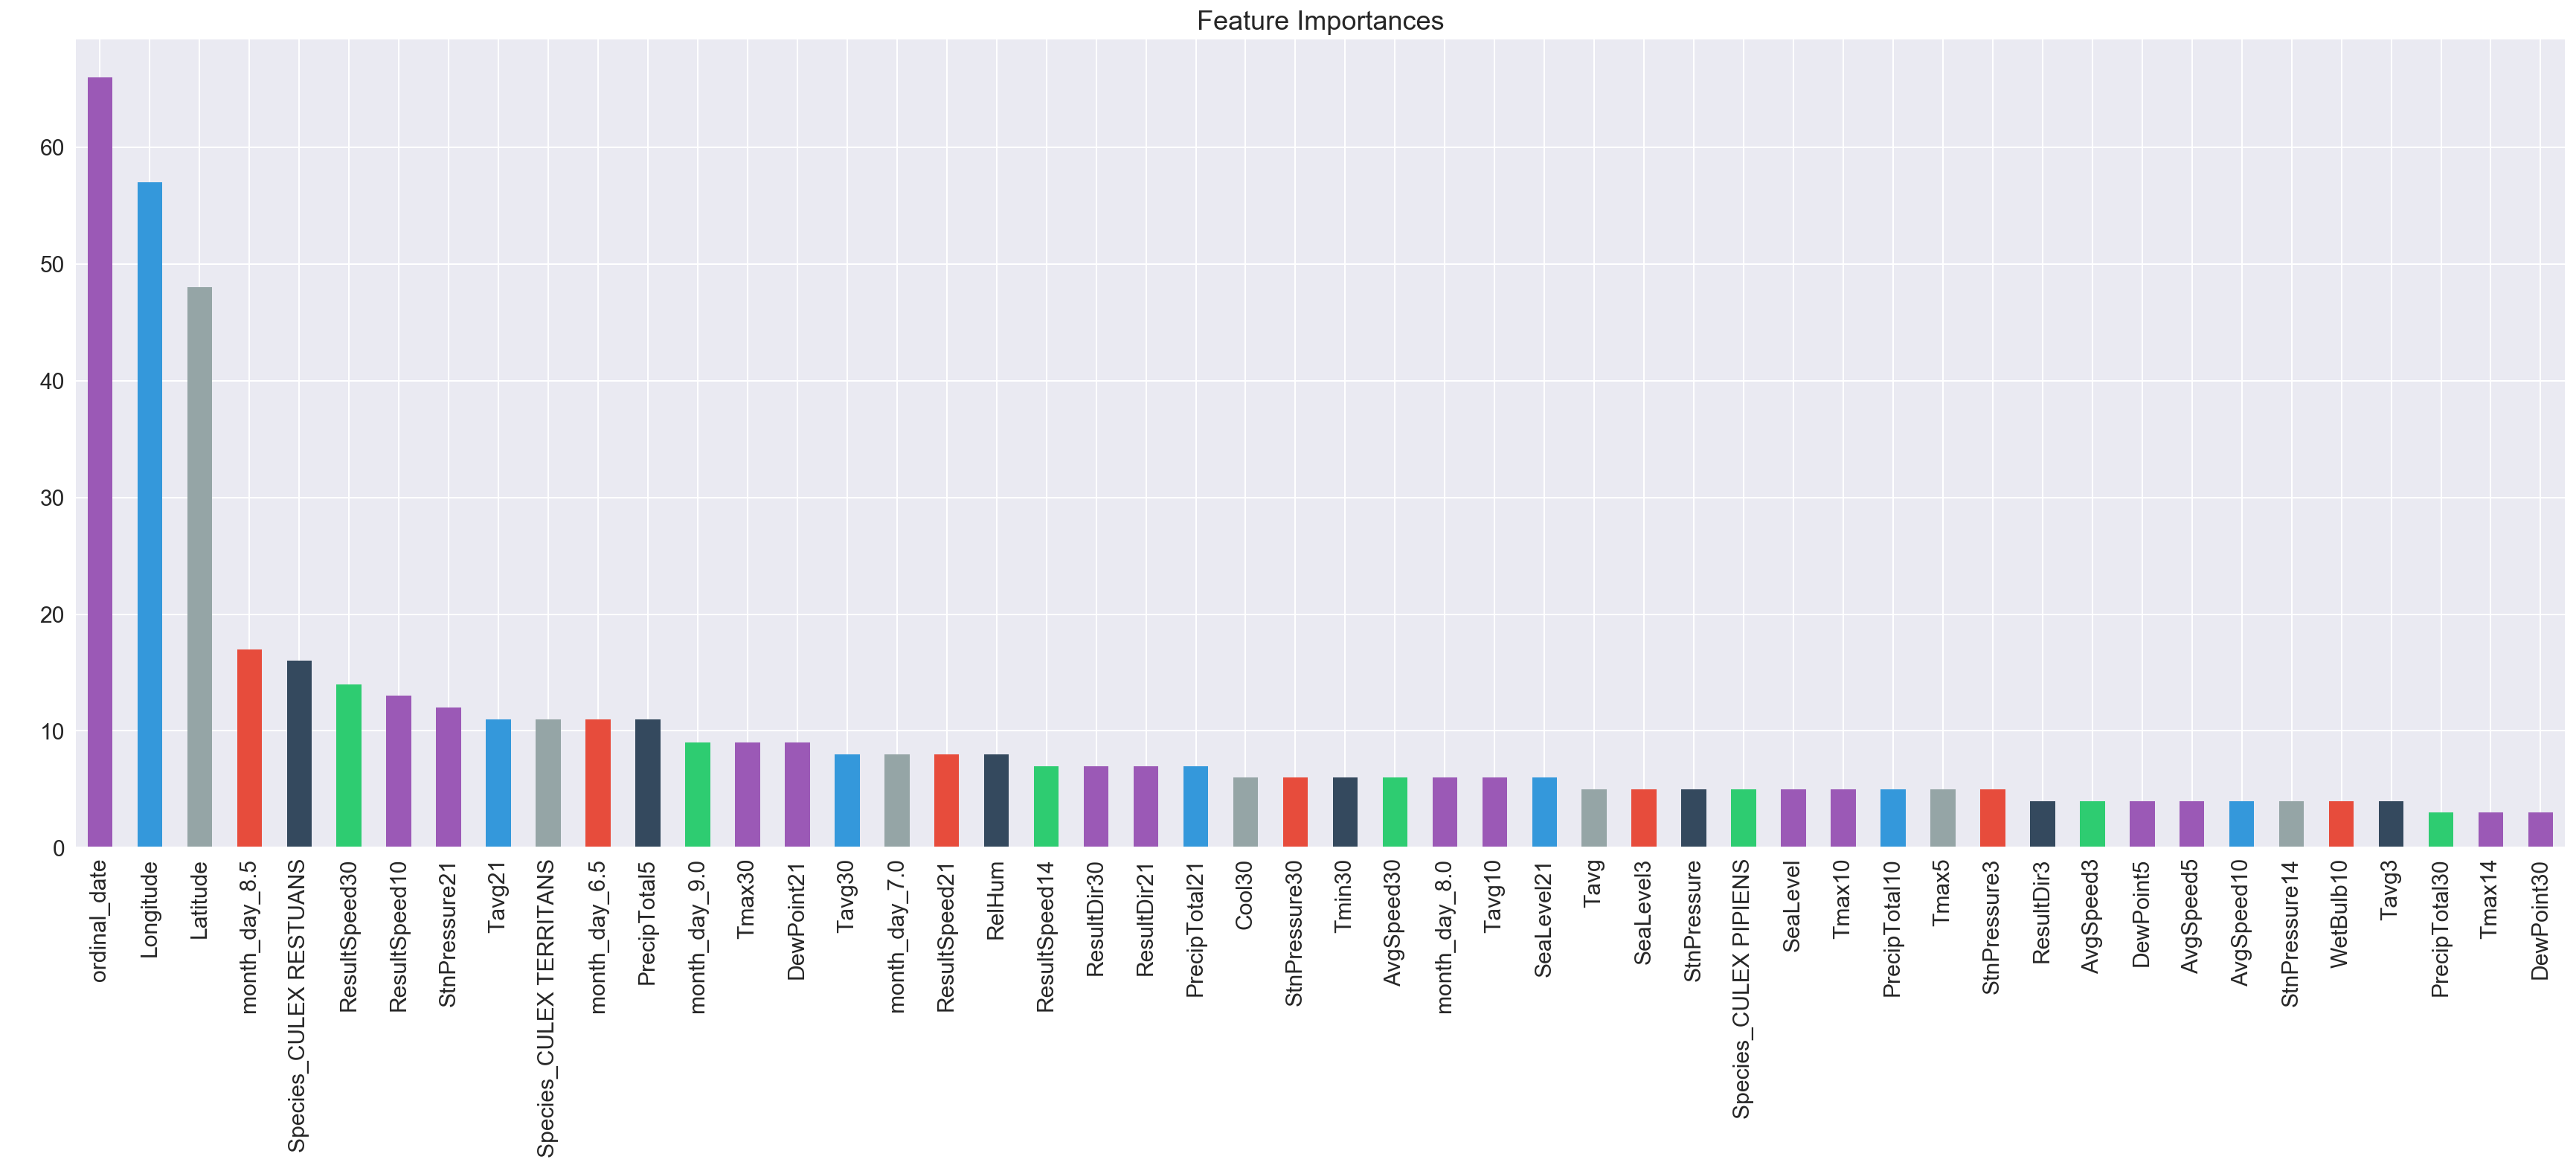

In [113]:
xgb2 = XGBClassifier(learning_rate =0.1,
                     n_estimators=1000,
                     max_depth=2,
                     min_child_weight=3,
                     gamma=0,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     objective= 'binary:logistic',
                     nthread=4,
                     scale_pos_weight=1, seed=27)

modelfit(xgb2, train_clean, predictors)

The top50 has shifted. new n_estimator value is 202

Keep tuning, :

In [114]:
param_test4 = {'subsample':np.linspace(0.5,1.0,num=6),
              'colsample_bytree':np.linspace(0.5,1.0,num=6)}

gs4 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, 
                                                   n_estimators=202,
                                                   max_depth=2,
                                                   min_child_weight=3,
                                                   gamma=0,
                                                   subsample=0.8,
                                                   colsample_bytree=0.8,
                                                   objective= 'binary:logistic',
                                                   nthread=4,
                                                   scale_pos_weight=1,
                                                   seed=27),
                         param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gs4.fit(train_clean[predictors],train_clean[target])
gs4.grid_scores_, gs4.best_params_, gs4.best_score_

/Users/saqibnizami/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.46855, std: 0.20875, params: {'colsample_bytree': 0.5, 'subsample': 0.5},
  mean: 0.47246, std: 0.19329, params: {'colsample_bytree': 0.5, 'subsample': 0.6},
  mean: 0.47805, std: 0.18939, params: {'colsample_bytree': 0.5, 'subsample': 0.7},
  mean: 0.48430, std: 0.20074, params: {'colsample_bytree': 0.5, 'subsample': 0.8},
  mean: 0.50007, std: 0.20748, params: {'colsample_bytree': 0.5, 'subsample': 0.9},
  mean: 0.49903, std: 0.20315, params: {'colsample_bytree': 0.5, 'subsample': 1.0},
  mean: 0.47237, std: 0.20290, params: {'colsample_bytree': 0.6, 'subsample': 0.5},
  mean: 0.46612, std: 0.19316, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.48834, std: 0.20131, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.49356, std: 0.20756, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.50031, std: 0.20642, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.50860, std: 0.19952, params: {'colsample_bytree': 0.6, 'subsample'

Seems like 'colsample_bytree' and 'subsample' are both 1.0
1.0 usually the max for these parameters, lets check around it:

In [120]:
param_test5 = {'subsample':np.linspace(0.95,1.0,3),
              'colsample_bytree':np.linspace(0.95,1.0,3)}

gs5 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, 
                                                   n_estimators=202,
                                                   max_depth=2,
                                                   min_child_weight=3,
                                                   gamma=0,
                                                   subsample=1,
                                                   colsample_bytree=1,
                                                   objective= 'binary:logistic',
                                                   nthread=4,
                                                   scale_pos_weight=1,
                                                   seed=27),
                         param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gs5.fit(train_clean[predictors],train_clean[target])
gs5.grid_scores_, gs5.best_params_, gs5.best_score_

/Users/saqibnizami/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.49555, std: 0.20880, params: {'colsample_bytree': 0.95, 'subsample': 0.95},
  mean: 0.51366, std: 0.21432, params: {'colsample_bytree': 0.95, 'subsample': 0.975},
  mean: 0.50699, std: 0.21074, params: {'colsample_bytree': 0.95, 'subsample': 1.0},
  mean: 0.50433, std: 0.22115, params: {'colsample_bytree': 0.975, 'subsample': 0.95},
  mean: 0.50018, std: 0.20872, params: {'colsample_bytree': 0.975, 'subsample': 0.975},
  mean: 0.50795, std: 0.20268, params: {'colsample_bytree': 0.975, 'subsample': 1.0},
  mean: 0.49534, std: 0.21872, params: {'colsample_bytree': 1.0, 'subsample': 0.95},
  mean: 0.50358, std: 0.21131, params: {'colsample_bytree': 1.0, 'subsample': 0.975},
  mean: 0.51234, std: 0.20570, params: {'colsample_bytree': 1.0, 'subsample': 1.0}],
 {'colsample_bytree': 0.95, 'subsample': 0.975},
 0.5136616811958173)

slightly better! time to tune regularization parameters i.e. alpha:

In [121]:
param_test6 = {'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}

gs6 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, 
                                                   n_estimators=202,
                                                   max_depth=2,
                                                   min_child_weight=3,
                                                   gamma=0,
                                                   subsample=0.975,
                                                   colsample_bytree=0.95,
                                                   objective= 'binary:logistic',
                                                   nthread=4,
                                                   scale_pos_weight=1,
                                                   seed=27),
                         param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gs6.fit(train_clean[predictors],train_clean[target])
gs6.grid_scores_, gs6.best_params_, gs6.best_score_

/Users/saqibnizami/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.51366, std: 0.21432, params: {'reg_alpha': 1e-05},
  mean: 0.51192, std: 0.21436, params: {'reg_alpha': 0.01},
  mean: 0.50020, std: 0.20406, params: {'reg_alpha': 0.1},
  mean: 0.49408, std: 0.21835, params: {'reg_alpha': 1},
  mean: 0.59920, std: 0.12609, params: {'reg_alpha': 100}],
 {'reg_alpha': 100},
 0.5991952691088669)

better than before, lets check closer to reg_alpha =100 :

In [122]:
param_test7 = {'reg_alpha':[90, 95, 100, 105, 110]}

gs7 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, 
                                                   n_estimators=202,
                                                   max_depth=2,
                                                   min_child_weight=3,
                                                   gamma=0,
                                                   subsample=0.975,
                                                   colsample_bytree=0.95,
                                                   objective= 'binary:logistic',
                                                   nthread=4,
                                                   scale_pos_weight=1,
                                                   seed=27),
                         param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gs7.fit(train_clean[predictors],train_clean[target])
gs7.grid_scores_, gs7.best_params_, gs7.best_score_

/Users/saqibnizami/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.51366, std: 0.21432, params: {'reg_alpha': 1e-05},
  mean: 0.51192, std: 0.21436, params: {'reg_alpha': 0.01},
  mean: 0.50020, std: 0.20406, params: {'reg_alpha': 0.1},
  mean: 0.49408, std: 0.21835, params: {'reg_alpha': 1},
  mean: 0.59920, std: 0.12609, params: {'reg_alpha': 100}],
 {'reg_alpha': 100},
 0.5991952691088669)

That's that. Time to update the model

[0]	train-auc:0.502367+0.00289905	test-auc:0.499703+0.0005944
[1]	train-auc:0.502367+0.00289905	test-auc:0.499703+0.0005944
[2]	train-auc:0.502367+0.00289905	test-auc:0.499703+0.0005944
[3]	train-auc:0.502998+0.00264762	test-auc:0.501817+0.00441428
[4]	train-auc:0.502881+0.0025246	test-auc:0.501756+0.00444071
[5]	train-auc:0.503482+0.00208703	test-auc:0.502873+0.00455914
[6]	train-auc:0.503482+0.00208703	test-auc:0.502873+0.00455914
[7]	train-auc:0.522695+0.0375708	test-auc:0.514451+0.0199144
[8]	train-auc:0.565619+0.0512068	test-auc:0.550771+0.0456885
[9]	train-auc:0.596728+0.0477286	test-auc:0.583838+0.0487326
[10]	train-auc:0.643001+0.0285444	test-auc:0.634541+0.0331772
[11]	train-auc:0.671164+0.0383777	test-auc:0.663968+0.0369039
[12]	train-auc:0.702198+0.00293411	test-auc:0.69507+0.015242
[13]	train-auc:0.703625+0.00512148	test-auc:0.695237+0.0141677
[14]	train-auc:0.709175+0.00410656	test-auc:0.695859+0.0152388
[15]	train-auc:0.714302+0.00777133	test-auc:0.698032+0.016439
[16]	tr

/Users/saqibnizami/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9467
AUC Score (Train): 0.810691
     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.499703      0.000594        0.502367       0.002899
1         0.499703      0.000594        0.502367       0.002899
2         0.499703      0.000594        0.502367       0.002899
3         0.501817      0.004414        0.502998       0.002648
4         0.501756      0.004441        0.502881       0.002525
5         0.502873      0.004559        0.503482       0.002087
6         0.502873      0.004559        0.503482       0.002087
7         0.514451      0.019914        0.522695       0.037571
8         0.550771      0.045688        0.565619       0.051207
9         0.583838      0.048733        0.596728       0.047729
10        0.634541      0.033177        0.643001       0.028544
11        0.663968      0.036904        0.671164       0.038378
12        0.695070      0.015242        0.702198       0.002934
13        0.695237      0.014168        0.70

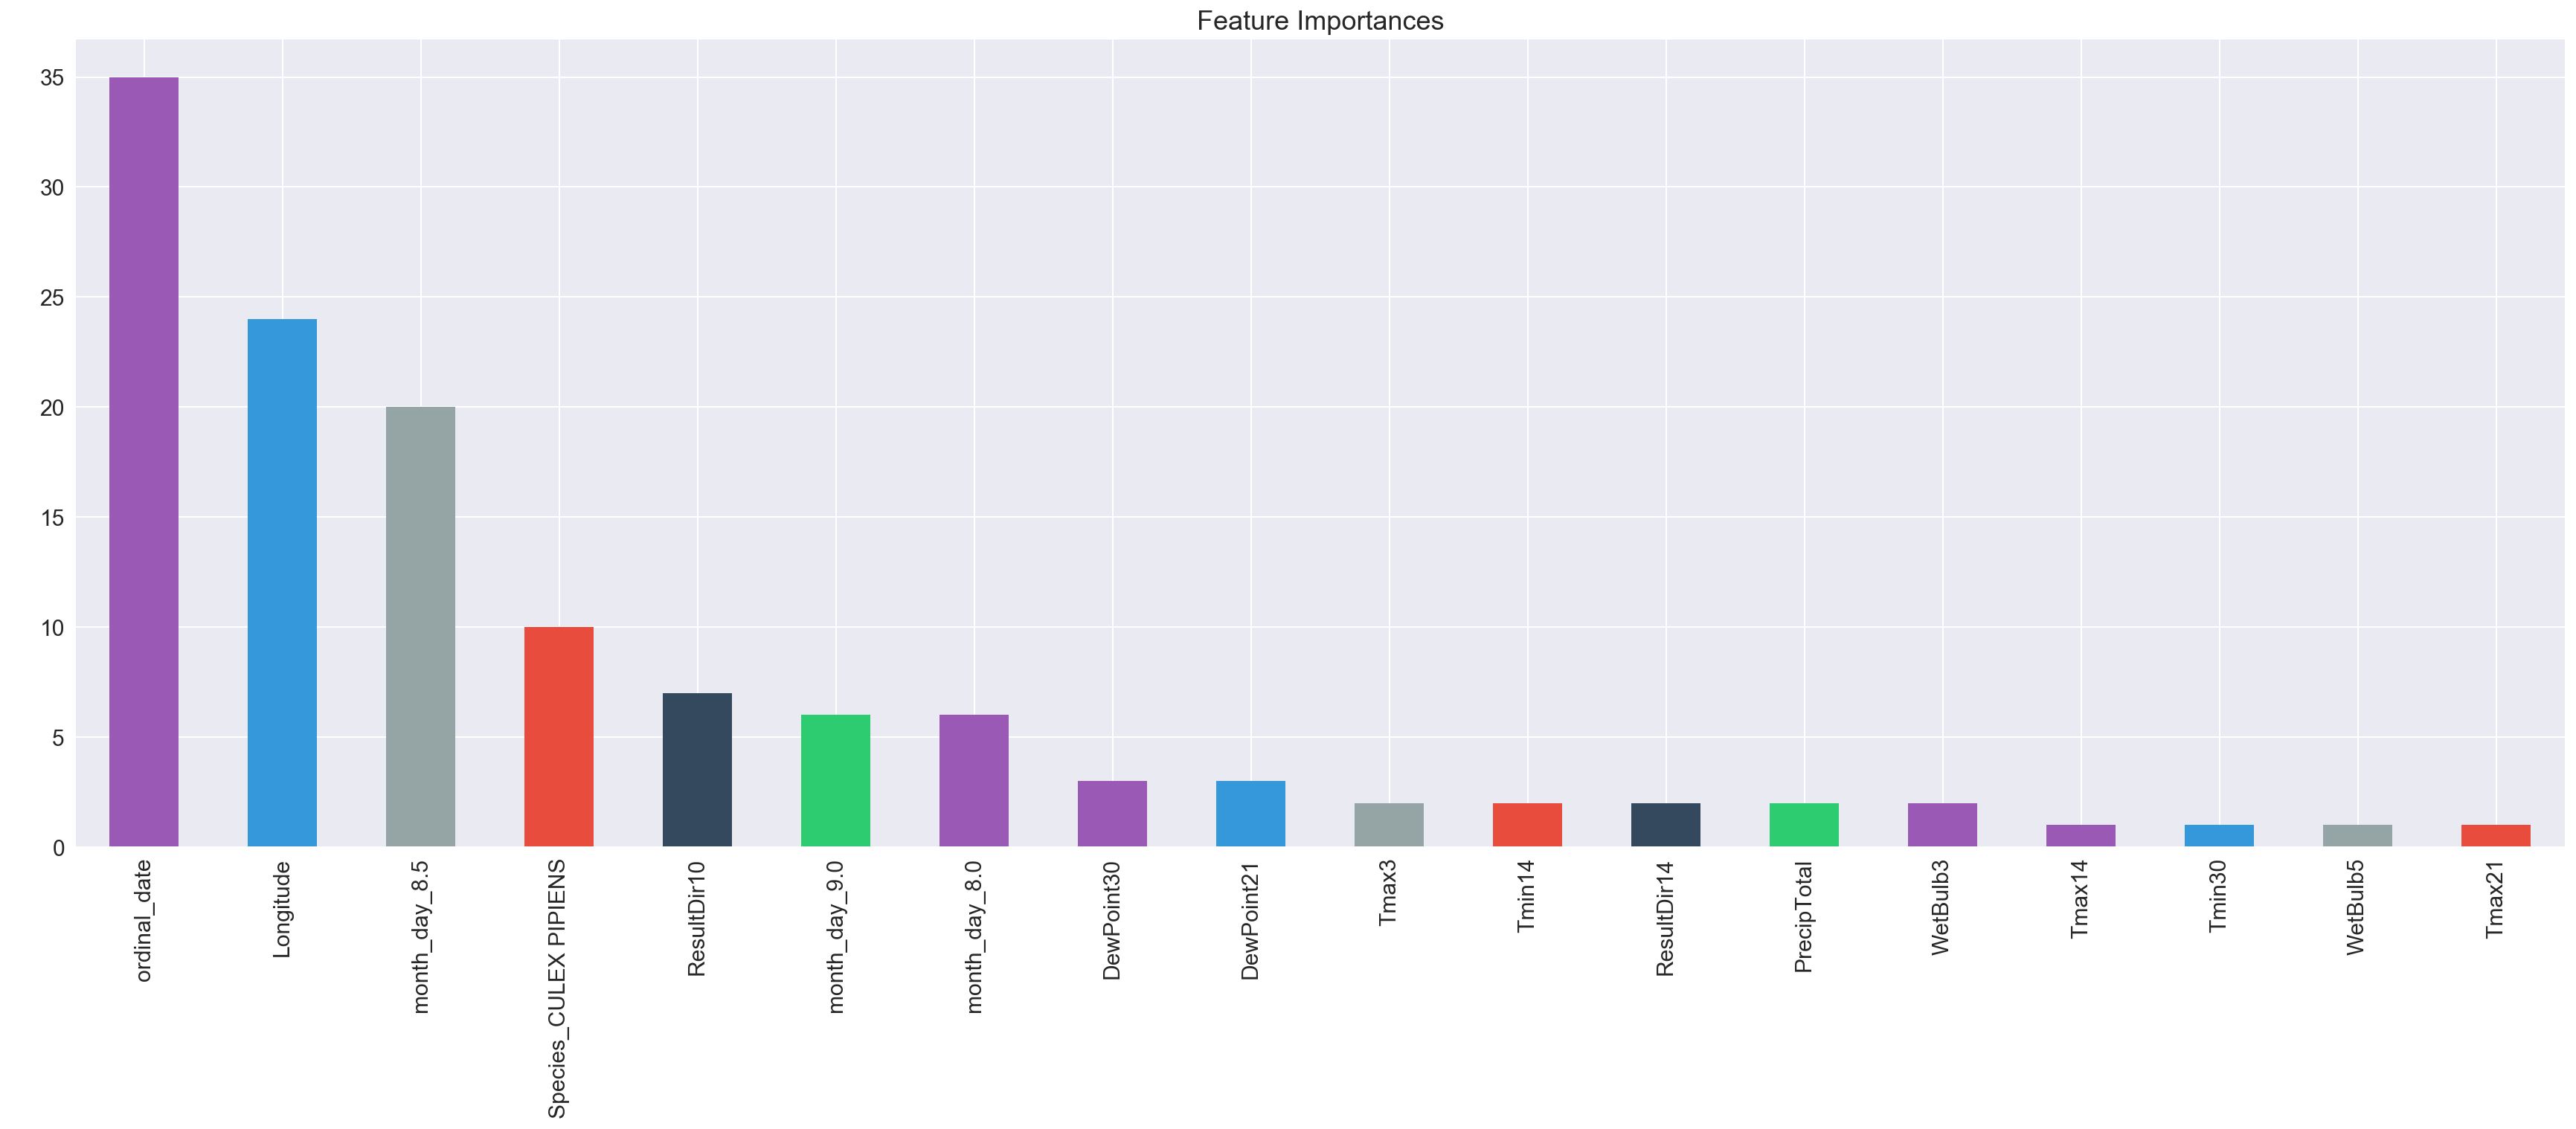

In [123]:
xgb3 = XGBClassifier(learning_rate =0.1,
                     n_estimators=1000,
                     max_depth=2,
                     min_child_weight=3,
                     gamma=0,
                     subsample=0.975,
                     colsample_bytree=0.95,
                     reg_alpha = 100,
                     objective= 'binary:logistic',
                     nthread=4,
                     scale_pos_weight=1, seed=27)

modelfit(xgb3, train_clean, predictors)

Nice! lower the learning rate and add more trees next:

[0]	train-auc:0.502367+0.00289905	test-auc:0.499703+0.0005944
[1]	train-auc:0.502367+0.00289905	test-auc:0.499703+0.0005944
[2]	train-auc:0.502367+0.00289905	test-auc:0.499703+0.0005944
[3]	train-auc:0.502367+0.00289905	test-auc:0.499703+0.0005944
[4]	train-auc:0.502367+0.00289905	test-auc:0.499703+0.0005944
[5]	train-auc:0.502367+0.00289905	test-auc:0.499703+0.0005944
[6]	train-auc:0.502367+0.00289905	test-auc:0.499703+0.0005944
[7]	train-auc:0.502367+0.00289905	test-auc:0.499703+0.0005944
[8]	train-auc:0.502367+0.00289905	test-auc:0.499703+0.0005944
[9]	train-auc:0.502367+0.00289905	test-auc:0.499703+0.0005944
[10]	train-auc:0.502367+0.00289905	test-auc:0.499703+0.0005944
[11]	train-auc:0.502367+0.00289905	test-auc:0.499703+0.0005944
[12]	train-auc:0.502367+0.00289905	test-auc:0.499703+0.0005944
[13]	train-auc:0.502367+0.00289905	test-auc:0.499703+0.0005944
[14]	train-auc:0.502367+0.00289905	test-auc:0.499703+0.0005944
[15]	train-auc:0.502367+0.00289905	test-auc:0.499703+0.0005944
[1

/Users/saqibnizami/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9467
AUC Score (Train): 0.808906
     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.499703      0.000594        0.502367       0.002899
1         0.499703      0.000594        0.502367       0.002899
2         0.499703      0.000594        0.502367       0.002899
3         0.499703      0.000594        0.502367       0.002899
4         0.499703      0.000594        0.502367       0.002899
5         0.499703      0.000594        0.502367       0.002899
6         0.499703      0.000594        0.502367       0.002899
7         0.499703      0.000594        0.502367       0.002899
8         0.499703      0.000594        0.502367       0.002899
9         0.499703      0.000594        0.502367       0.002899
10        0.499703      0.000594        0.502367       0.002899
11        0.499703      0.000594        0.502367       0.002899
12        0.499703      0.000594        0.502367       0.002899
13        0.499703      0.000594        0.50

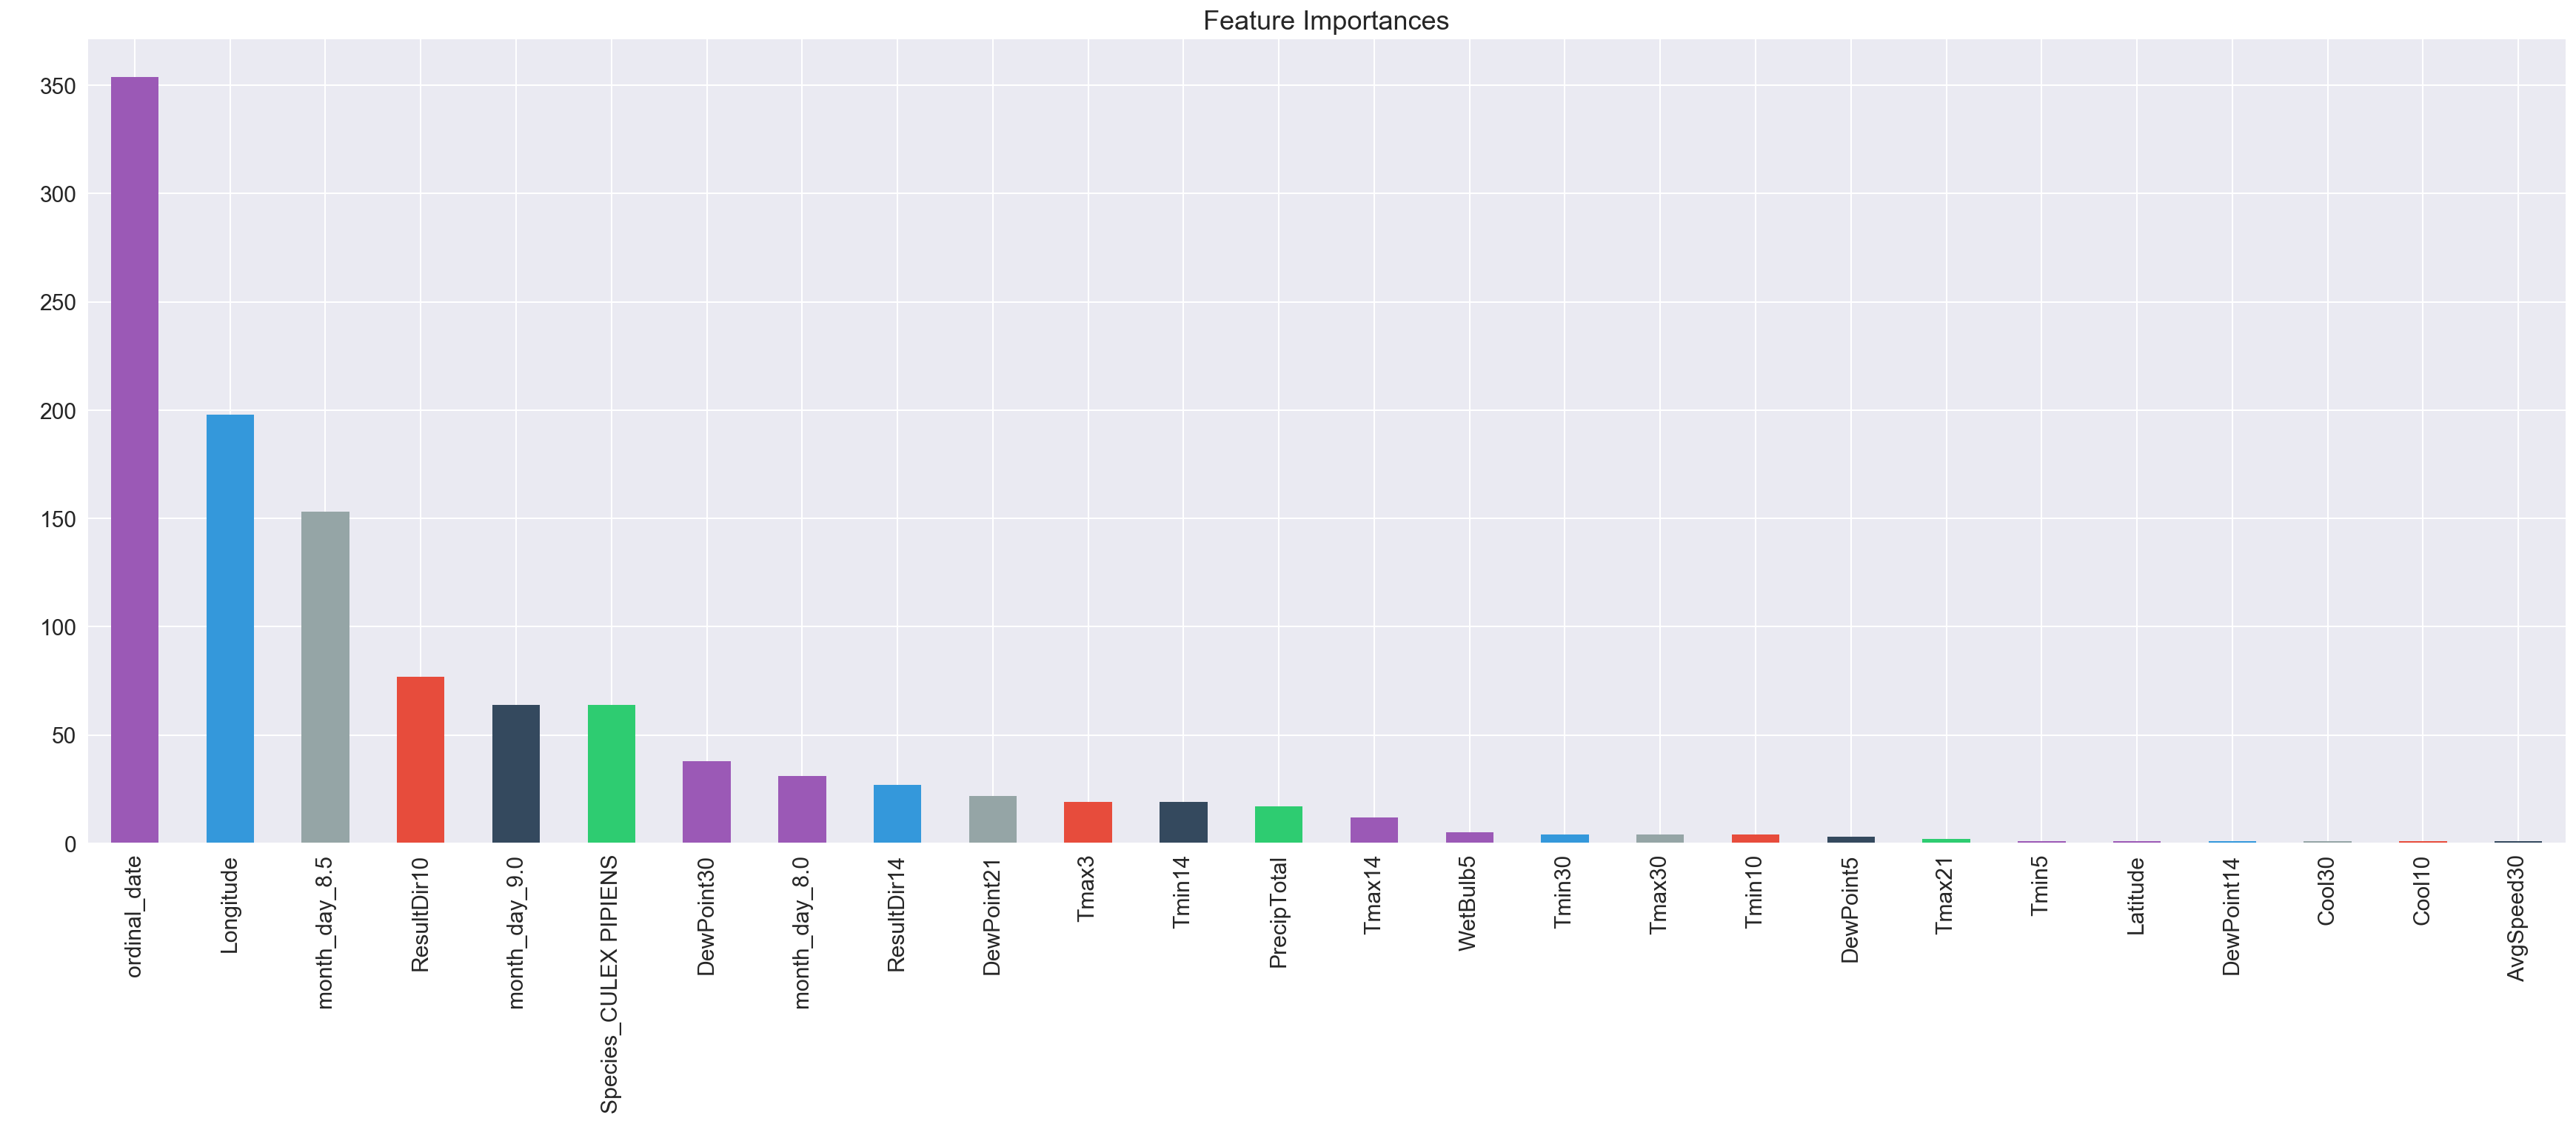

In [124]:
xgb4 = XGBClassifier(learning_rate =0.01,
                     n_estimators=5000,
                     max_depth=2,
                     min_child_weight=3,
                     gamma=0,
                     subsample=0.975,
                     colsample_bytree=0.95,
                     reg_alpha = 100,
                     objective= 'binary:logistic',
                     nthread=4,
                     scale_pos_weight=1, seed=27)

modelfit(xgb4, train_clean, predictors)

[0]	train-auc:0.502367+0.00289905	test-auc:0.499703+0.0005944
[1]	train-auc:0.502367+0.00289905	test-auc:0.499703+0.0005944
[2]	train-auc:0.502367+0.00289905	test-auc:0.499703+0.0005944
[3]	train-auc:0.502367+0.00289905	test-auc:0.499703+0.0005944
[4]	train-auc:0.502367+0.00289905	test-auc:0.499703+0.0005944
[5]	train-auc:0.502367+0.00289905	test-auc:0.499703+0.0005944
[6]	train-auc:0.502367+0.00289905	test-auc:0.499703+0.0005944
[7]	train-auc:0.502367+0.00289905	test-auc:0.499703+0.0005944
[8]	train-auc:0.502367+0.00289905	test-auc:0.499703+0.0005944
[9]	train-auc:0.502367+0.00289905	test-auc:0.499703+0.0005944
[10]	train-auc:0.502367+0.00289905	test-auc:0.499703+0.0005944
[11]	train-auc:0.502367+0.00289905	test-auc:0.499703+0.0005944
[12]	train-auc:0.502367+0.00289905	test-auc:0.499703+0.0005944
[13]	train-auc:0.502367+0.00289905	test-auc:0.499703+0.0005944
[14]	train-auc:0.502367+0.00289905	test-auc:0.499703+0.0005944
[15]	train-auc:0.502367+0.00289905	test-auc:0.499703+0.0005944
[1

/Users/saqibnizami/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9467
AUC Score (Train): 0.808906
     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.499703      0.000594        0.502367       0.002899
1         0.499703      0.000594        0.502367       0.002899
2         0.499703      0.000594        0.502367       0.002899
3         0.499703      0.000594        0.502367       0.002899
4         0.499703      0.000594        0.502367       0.002899
5         0.499703      0.000594        0.502367       0.002899
6         0.499703      0.000594        0.502367       0.002899
7         0.499703      0.000594        0.502367       0.002899
8         0.499703      0.000594        0.502367       0.002899
9         0.499703      0.000594        0.502367       0.002899
10        0.499703      0.000594        0.502367       0.002899
11        0.499703      0.000594        0.502367       0.002899
12        0.499703      0.000594        0.502367       0.002899
13        0.499703      0.000594        0.50

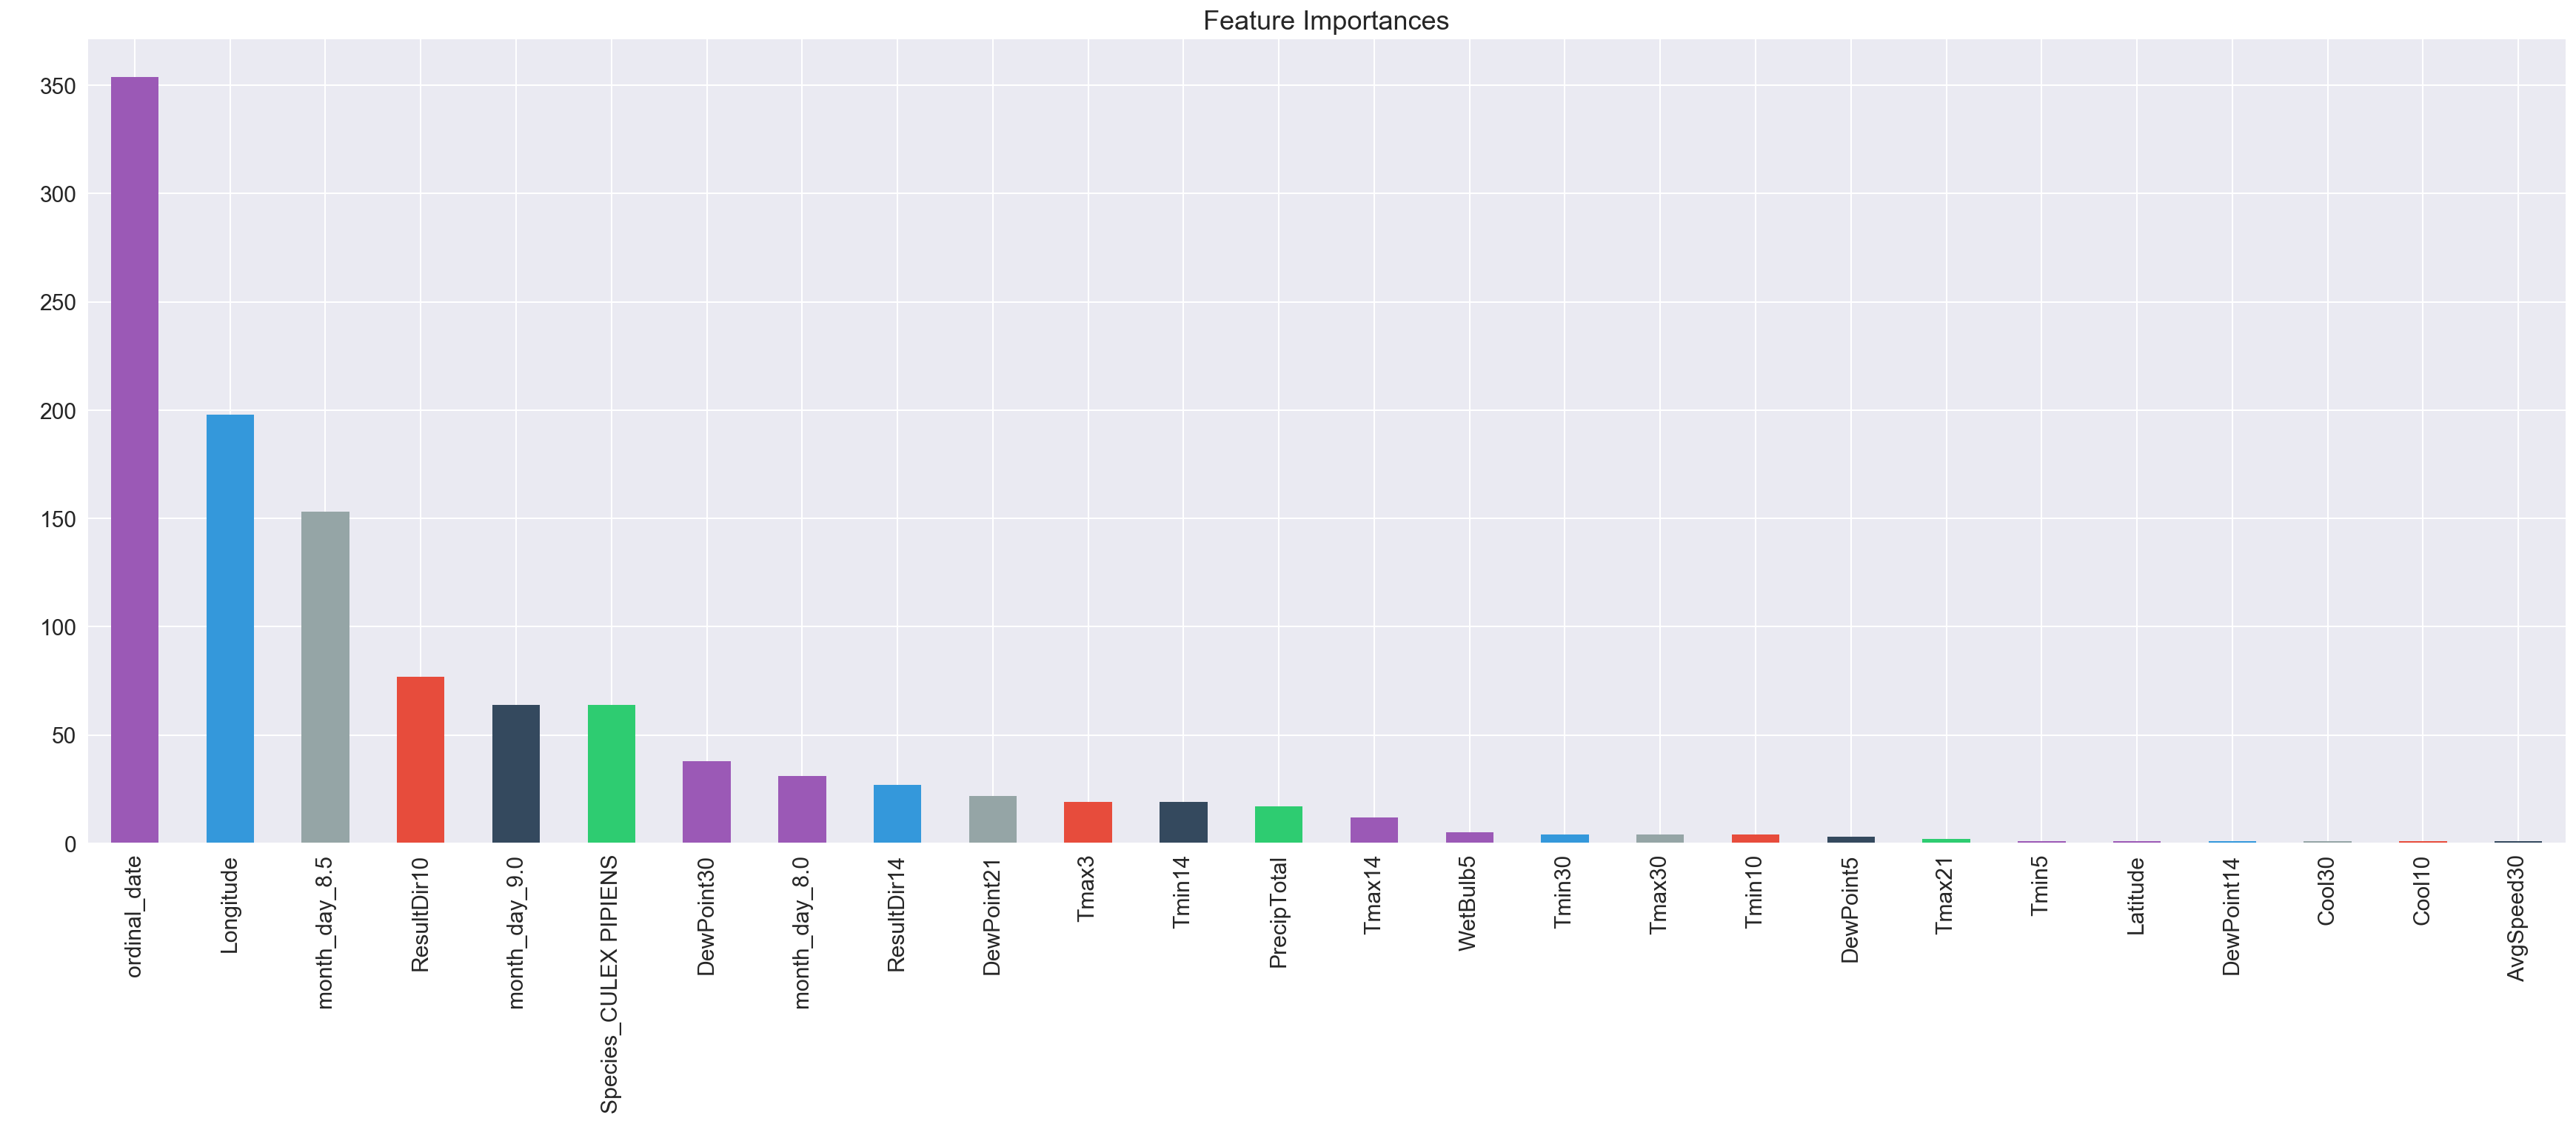

In [128]:
xgb5 = XGBClassifier(learning_rate =0.01,
                     n_estimators=621,
                     max_depth=2,
                     min_child_weight=3,
                     gamma=0,
                     subsample=0.975,
                     colsample_bytree=0.95,
                     reg_alpha = 100,
                     objective= 'binary:logistic',
                     nthread=4,
                     scale_pos_weight=1, seed=27)

modelfit(xgb5, train_clean, predictors)

---
### XGBC HyperParameter Tuning on TTS

In [48]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = (30, 10)

In [65]:
test_clean.columns, train_clean[predictors].columns

(Index(['Latitude', 'Longitude', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb',
        'Heat', 'Cool', 'PrecipTotal',
        ...
        'Species_CULEX TERRITANS', 'month_day_6.5', 'month_day_7.0',
        'month_day_7.5', 'month_day_8.0', 'month_day_8.5', 'month_day_9.0',
        'month_day_9.5', 'month_day_10.0', 'RelHum'],
       dtype='object', length=142),
 Index(['Latitude', 'Longitude', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb',
        'Heat', 'Cool', 'PrecipTotal',
        ...
        'Species_CULEX TERRITANS', 'month_day_6.5', 'month_day_7.0',
        'month_day_7.5', 'month_day_8.0', 'month_day_8.5', 'month_day_9.0',
        'month_day_9.5', 'month_day_10.0', 'RelHum'],
       dtype='object', length=142))

In [66]:
# trainf = train_clean.drop(columns=['WnvPresent','NumMosquitos'])
trainf = train_clean.drop(columns=['WnvPresent', 'NumMosquitos_sum'])
predictors = list(trainf.columns.values)
target = 'WnvPresent'

In [67]:
X = train_clean[predictors]
y = train_clean[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33,
                                                    stratify = y,
                                                    random_state=42)

In [68]:
# 
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['WnvPresent'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print( "\nModel Report")
    print( "Accuracy : %.4g" % accuracy_score(dtrain['WnvPresent'].values, dtrain_predictions))
    print( "AUC Score (Train): %f" % roc_auc_score(dtrain['WnvPresent'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)[:50]
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [64]:
pd.Series(xgb1.get_booster().get_fscore()).sort_values(ascending=False)[:50]

f1      151
f0      105
f48      81
f124     32
f115     32
f111     28
f125     24
f112     24
f114     24
f127     23
f137     22
f108     21
f129     20
f101     20
f126     19
f86      18
f69      17
f102     16
f122     16
f85      16
f128     15
f75      15
f113     14
f15      14
f98      14
f99      14
f88      13
f49      13
f87      13
f117     13
f121     13
f83      13
f109     12
f60      12
f100     12
f90      11
f10      11
f141     11
f76      11
f72      11
f104     11
f95      11
f132     10
f136     10
f2       10
f77       9
f12       9
f57       9
f133      9
f138      9
dtype: int64

/Users/saqibnizami/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9519
AUC Score (Train): 0.932598


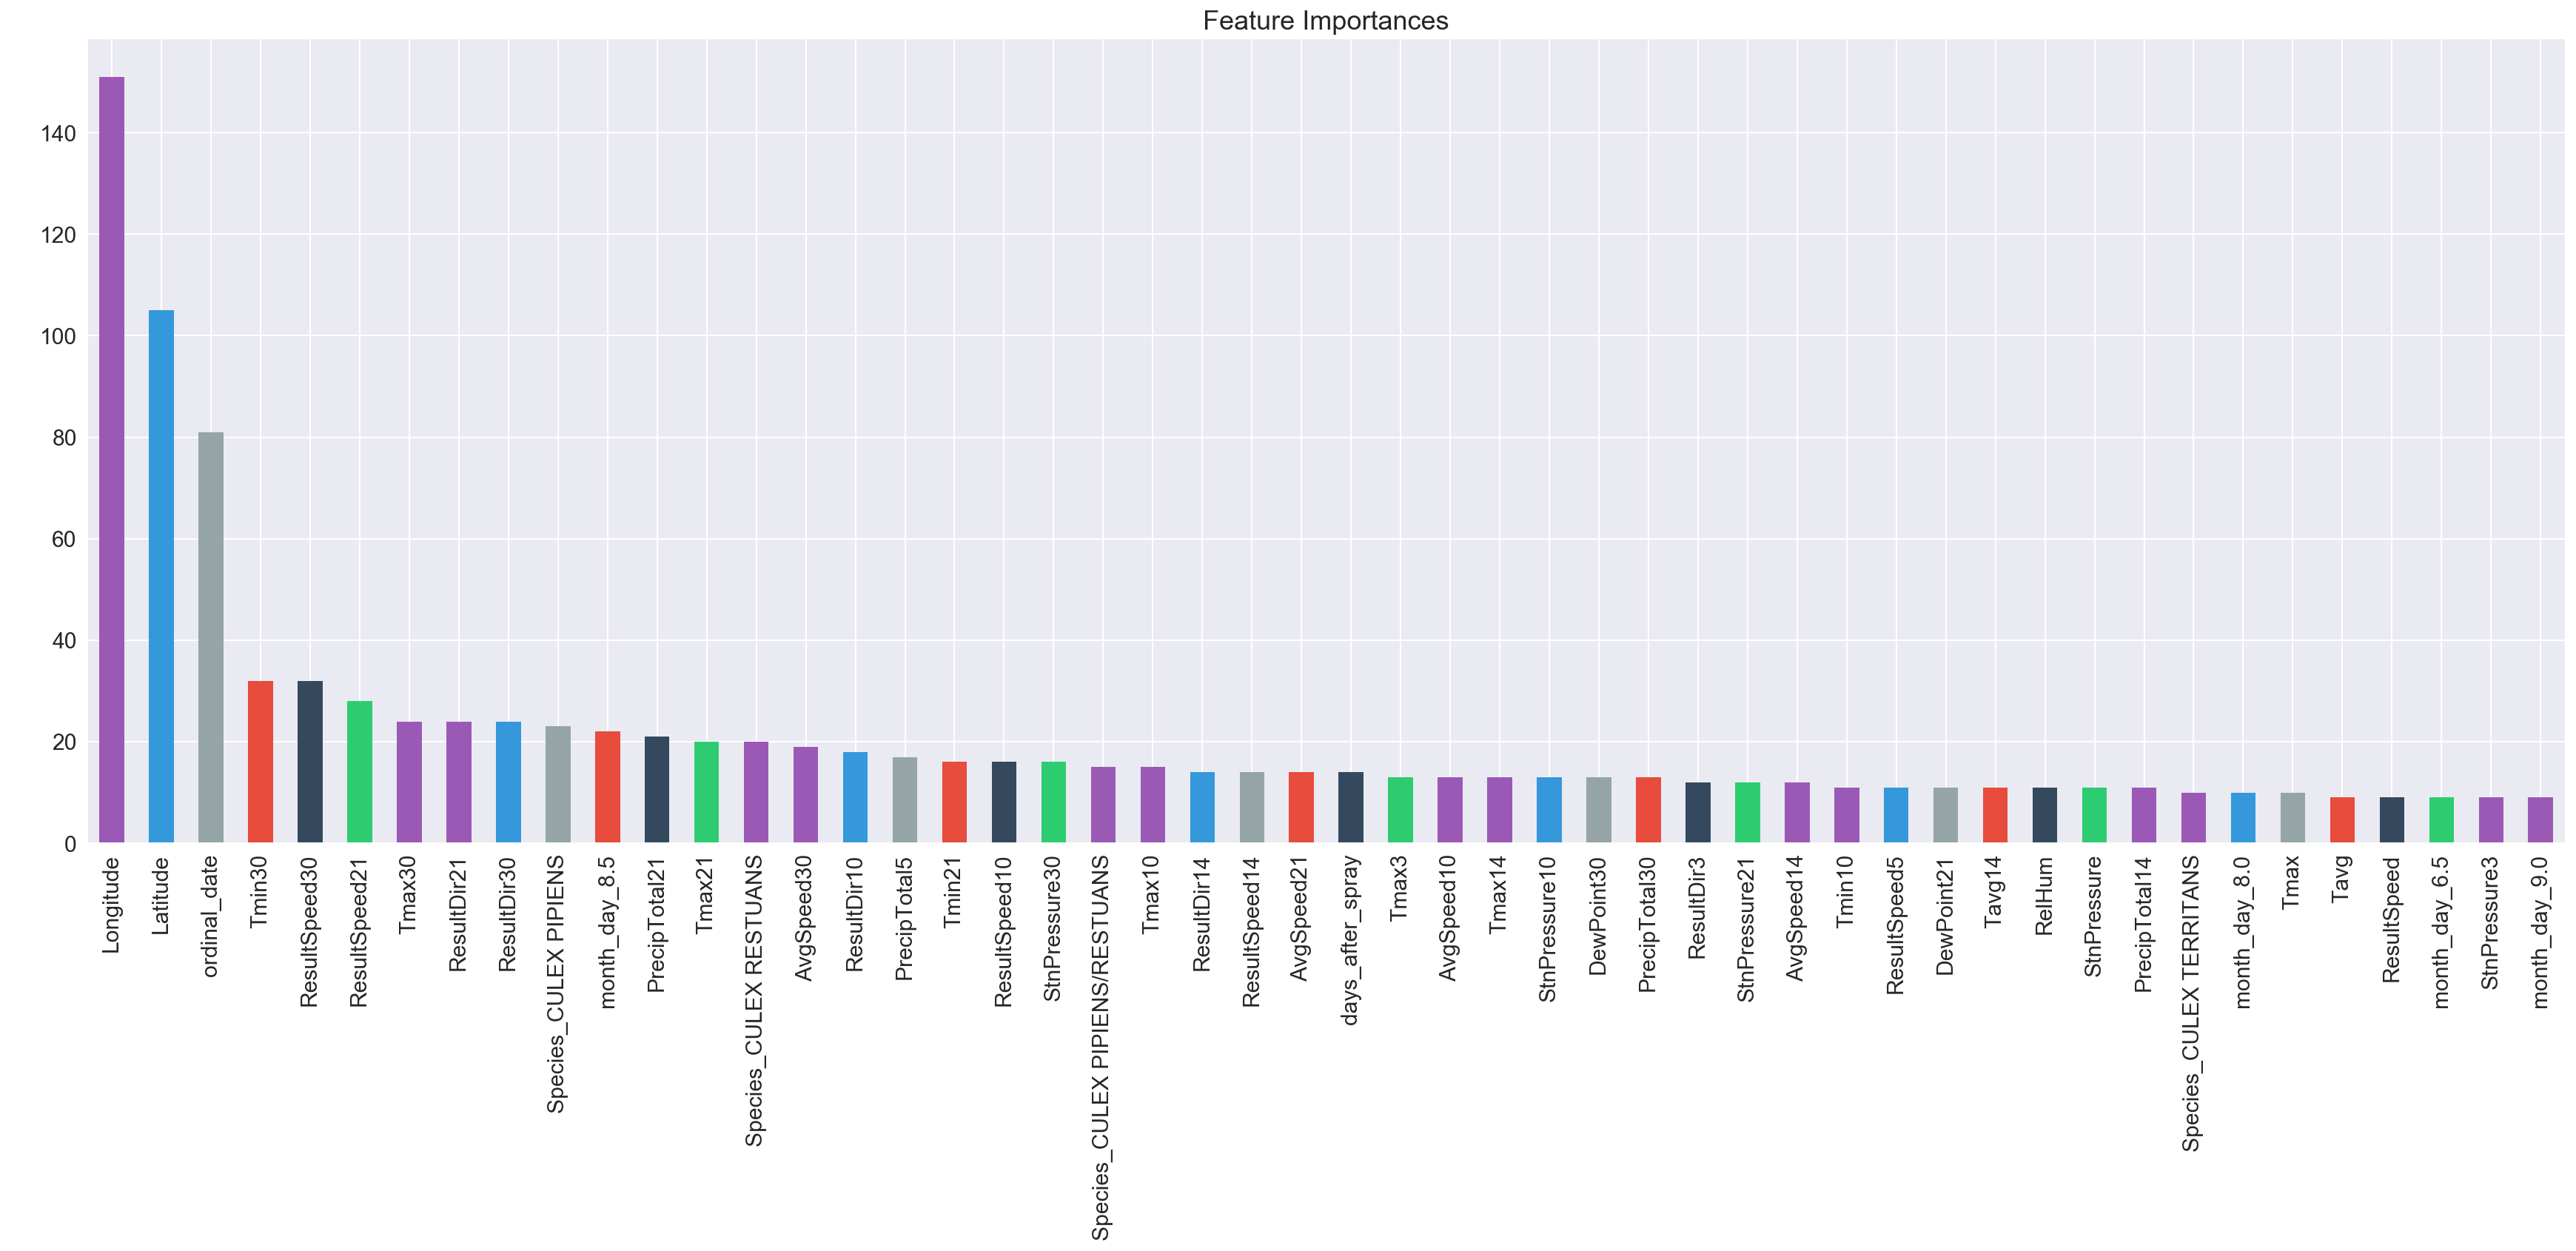

In [69]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train_clean, predictors)

In [73]:
param_test1 = {'max_depth':range(3,10,2),
               'min_child_weight':range(1,6,2)
              }

gs1 = GridSearchCV(estimator= XGBClassifier(learning_rate=0.1,
                                            n_estimators=140,
                                            max_depth=5,
                                            min_child_weight=1,
                                            gamma=0,
                                            subsample=0.8,
                                            colsample_bytree=0.8,
                                            objective='binary:logistic',
                                            nthread=4,
                                            scale_pos_weight=1,
                                            seed=19), 
                   param_grid = param_test1, scoring='roc_auc', n_jobs=2, iid=False, cv=5)

gs1.fit(train_clean[predictors], train_clean[target])
gs1.grid_scores_, gs1.best_params_, gs1.best_score_


/Users/saqibnizami/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.45264, std: 0.18858, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.45388, std: 0.20173, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.42881, std: 0.19080, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.40085, std: 0.17588, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.41362, std: 0.19346, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.39974, std: 0.18977, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.38697, std: 0.17307, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.38433, std: 0.18118, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.38291, std: 0.18402, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.37486, std: 0.17805, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.39139, std: 0.19215, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.38040, std: 0.17780, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 3, 'min_child_weight': 3

In [74]:
param_test2 = {
 'max_depth':[2,3,4],
 'min_child_weight':[2,3,4]
}
gs2 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1,
                                                  n_estimators=140,
                                                  max_depth=5,
                                                  min_child_weight=2,
                                                  gamma=0,
                                                  subsample=0.8,
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic',
                                                  nthread=4,
                                                  scale_pos_weight=1,
                                                  seed=27), 
                        param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gs2.fit(train_clean[predictors],train_clean[target])
gs2.grid_scores_, gs2.best_params_, gs2.best_score_

/Users/saqibnizami/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.49467, std: 0.19820, params: {'max_depth': 2, 'min_child_weight': 2},
  mean: 0.50105, std: 0.20949, params: {'max_depth': 2, 'min_child_weight': 3},
  mean: 0.50195, std: 0.21210, params: {'max_depth': 2, 'min_child_weight': 4},
  mean: 0.43730, std: 0.19312, params: {'max_depth': 3, 'min_child_weight': 2},
  mean: 0.44810, std: 0.20402, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.44957, std: 0.20267, params: {'max_depth': 3, 'min_child_weight': 4},
  mean: 0.41565, std: 0.18760, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: 0.39707, std: 0.19184, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: 0.40717, std: 0.19945, params: {'max_depth': 4, 'min_child_weight': 4}],
 {'max_depth': 2, 'min_child_weight': 4},
 0.5019504678583944)

In [175]:
top50 = pd.Series(xgb1.get_booster().get_fscore()).sort_values(ascending=False)[:50]

In [176]:
top50.index

Index(['Longitude', 'Latitude', 'ordinal_date', 'Tmin30', 'ResultSpeed30',
       'ResultSpeed21', 'Tmax30', 'ResultDir21', 'ResultDir30',
       'Species_CULEX PIPIENS', 'month_day_8.5', 'PrecipTotal21', 'Tmax21',
       'Species_CULEX RESTUANS', 'AvgSpeed30', 'ResultDir10', 'PrecipTotal5',
       'Tmin21', 'ResultSpeed10', 'StnPressure30',
       'Species_CULEX PIPIENS/RESTUANS', 'Tmax10', 'ResultDir14',
       'ResultSpeed14', 'AvgSpeed21', 'days_after_spray', 'Tmax3',
       'AvgSpeed10', 'Tmax14', 'StnPressure10', 'DewPoint30', 'PrecipTotal30',
       'ResultDir3', 'StnPressure21', 'AvgSpeed14', 'Tmin10', 'ResultSpeed5',
       'DewPoint21', 'Tavg14', 'RelHum', 'StnPressure', 'PrecipTotal14',
       'Species_CULEX TERRITANS', 'month_day_8.0', 'Tmax', 'Tavg',
       'ResultSpeed', 'month_day_6.5', 'StnPressure3', 'month_day_9.0'],
      dtype='object')

In [188]:
train_clean[train_clean.WnvPresent > 0]

Latitude  Longitude  WnvPresent  Tmax  Tmin  Tavg  DewPoint  WetBulb  \
528   41.686398 -87.531635           1    85    69    77        69       71   
568   41.673408 -87.599862           1    83    70    77        60       66   
576   41.673408 -87.599862           1    83    70    77        60       66   
581   41.673408 -87.599862           1    83    70    77        60       66   
675   41.954690 -87.800991           1    92    69    81        62       69   
676   41.954690 -87.800991           1    92    69    81        62       69   
682   41.974089 -87.824812           1    92    69    81        62       69   
701   41.688324 -87.676709           1    91    69    80        63       70   
713   41.731922 -87.677512           1    91    69    80        63       70   
751   41.868077 -87.666901           1    91    69    80        63       70   
758   41.662014 -87.724608           1    91    69    80        63       70   
760   41.662014 -87.724608           1    91    69    80        63       70   
792   41.963976 -87.691810           1    91    69    80        63       70   
802   42.008314 -87.777921           1    92    69    81        62       69   
839   41.940160 -87.794896           1    92    69    81        62       69   
863   41.778297 -87.752411           1    91    69    80        63       70   
901   41.821582 -87.627796           1    91    69    80        63       70   
905   41.803423 -87.642984           1    91    69    80        63       70   
923   41.726465 -87.585413           1    91    69    80        63       70   
949   41.702724 -87.536497           1    91    69    80        63       70   
965   41.731922 -87.677512           1    91    73    82        66       72   
1008  41.726465 -87.585413           1    91    73    82        66       72   
1017  41.680946 -87.535198           1    91    73    82        66       72   
1052  41.974089 -87.824812           1    91    72    82        73       76   
1077  41.999129 -87.795585           1    91    72    82        73       76   
1078  41.999129 -87.795585           1    91    72    82        73       76   
1090  41.944869 -87.832763           1    91    72    82        73       76   
1092  41.944869 -87.832763           1    91    72    82        73       76   
1094  42.011601 -87.811506           1    91    72    82        73       76   
1136  41.725517 -87.614258           1    92    73    83        73       76   
1150  42.008314 -87.777921           1    91    72    82        73       76   
1151  42.008314 -87.777921           1    91    72    82        73       76   
1166  41.970248 -87.787992           1    91    72    82        73       76   
1174  41.903002 -87.688267           1    92    73    83        73       76   
1208  41.803423 -87.642984           1    92    73    83        73       76   
1228  41.673408 -87.599862           1    87    74    81        72       74   
1231  41.673408 -87.599862           1    87    74    81        72       74   
1234  41.726465 -87.585413           1    87    74    81        72       74   
1238  41.704572 -87.565666           1    87    74    81        72       74   
1244  41.702724 -87.536497           1    87    74    81        72       74   
1256  41.740641 -87.546587           1    85    73    79        71       73   
1264  41.954690 -87.800991           1    80    71    76        67       70   
1270  41.974089 -87.824812           1    80    71    76        67       70   
1272  41.921600 -87.666455           1    81    72    77        69       71   
1279  41.867108 -87.654224           1    81    72    77        69       71   
1280  41.867108 -87.654224           1    81    72    77        69       71   
1282  41.896282 -87.655232           1    81    72    77        69       71   
1289  41.688324 -87.676709           1    81    72    77        69       71   
1302  41.999129 -87.795585           1    80    71    76        67       70   
1303  41.999129 -87.795585           1    80    71    76 

In [168]:
# train test split 
y = train_clean['WnvPresent']
X = train_clean[top50]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify = y,
                                                    random_state=42)


# Using RandomForestClassifier
# rfc = RandomForestClassifier(random_state=19)

In [169]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6602, 142), (2201, 142), (6602,), (2201,))

In [177]:

bbc = BalancedBaggingClassifier(base_estimator=xgb5,
#                                 n_estimators=621, <-- optimal tree number for 0.01 learning rate
                                random_state=10)

In [178]:
bbc.fit(X_train,y_train)

bbc_predict = bbc.predict(X_test)
bbc_score = recall_score(y_test, bbc_predict)

print ("BBC Test Score:", bbc_score)

BBC Test Score: 0.0


In [145]:
bbc_confusion = pd.DataFrame(np.array(confusion_matrix(y_test, bbc_predict)),
                         index = ['is_not_abnormal', 'is_abnormal'],
                        columns=['predicted_not_abnormal','predicted_abnormal'])
bbc_confusion

predicted_not_abnormal  predicted_abnormal
is_not_abnormal                    1434                 650
is_abnormal                          25                  92

In [179]:
bbc_params = {
#     'n_estimators':np.arange(5,20),
    'warm_start': [True, False]
#     'max_samples': [1,2]
#     'max_features': np.arange(1,10)  these break gridsearch so put them in manually
}

bbc_gs = GridSearchCV(bbc,
                     param_grid=bbc_params,
                     scoring='roc_auc', # try roc_auc
                     cv = 10)

In [180]:
bbc_gs.fit(X_train,y_train)
bbc_gs_score = bbc_gs.score(X_test, y_test)

print("Best Params: ", bbc_gs.best_params_)
print ("BBC Test Score:", bbc_gs_score)

Best Params:  {'warm_start': True}
BBC Test Score: 0.5


In [154]:
bbc_gs.fit(X,y)
test_pred2 = bbc_gs.predict(test_clean)
test_pred2 = pd.DataFrame(test_pred2)
test_pred2['Id'] = [i for i in range(1,116294)]
test_pred2['WnvPresent'] = test_pred2[0]
test_pred2.drop([0],axis=1,inplace=True)
test_pred2['WnvPresent'].value_counts()

KeyboardInterrupt: 

In [195]:
test_pred2.to_csv('test_pred_8san.csv',index=False)

---

#### pipeline

---

In [149]:
from imblearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

In [184]:
# Instanciate a PCA object for the sake of easy visualisation
ss = StandardScaler()
# pca = PCA()
bbc = BalancedBaggingClassifier(base_estimator=xgb5, 
                                warm_start=True,
                                n_estimators=10,
                                random_state=10)
bbc_params = {
#     'n_estimators':np.arange(5,20),
    'warm_start': [True]
#     'max_samples': [1,2]
#     'max_features': np.arange(1,10)  these break gridsearch so put them in manually
}

bbc_gs = GridSearchCV(bbc,
                     param_grid=bbc_params,
                     scoring='roc_auc', # try roc_auc
                     cv = 10)
# # Create the samplers
# enn = EditedNearestNeighbours()
# renn = RepeatedEditedNearestNeighbours()
# # Create the classifier
# xgb = X(1)
# # Make the splits
# X_train, X_test, y_train, y_test = tts(X, y, random_state=42
# Add one transformers and two samplers in the pipeline object

# reinstantiate the bbc and xgb with the best params
pipeline = make_pipeline(ss, bbc_gs)

pipeline.fit(X_train, y_train)

y_hat = pipeline.predict(X_test)

print(classification_report(y_test, y_hat))

             precision    recall  f1-score   support

          0       0.95      1.00      0.97      2084
          1       0.00      0.00      0.00       117

avg / total       0.90      0.95      0.92      2201



/Users/saqibnizami/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [160]:
pipeline.steps

[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('pca',
  PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)),
 ('gridsearchcv', GridSearchCV(cv=10, error_score='raise',
         estimator=BalancedBaggingClassifier(base_estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bytree=0.95, gamma=0, learning_rate=0.01,
         max_delta_step=0, max_depth=2, min_child_weight=3, missing=None,
         n_estimators=621, n_jobs=1, nthread=4, obj...          random_state=10, ratio='auto', replacement=False, verbose=0,
               warm_start=True),
         fit_params=None, iid=True, n_jobs=1,
         param_grid={'warm_start': [True]}, pre_dispatch='2*n_jobs',
         refit=True, return_train_score='warn', scoring='roc_auc', verbose=0))]

In [161]:
test_clean.shape

(116293, 142)

In [163]:
test_clean.shape

(116293, 142)

In [166]:
X_test.columns.values

array(['Latitude', 'Longitude', 'Tmax', 'Tmin', 'Tavg', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'PrecipTotal', 'StnPressure',
       'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed',
       'days_after_spray', 'heavy_rain', 'light_rain', 'light_rain_past1',
       'heavy_rain_past1', 'light_rain_past2', 'heavy_rain_past2',
       'light_rain_past3', 'heavy_rain_past3', 'light_rain_past4',
       'heavy_rain_past4', 'light_rain_past5', 'heavy_rain_past5',
       'light_rain_past6', 'heavy_rain_past6', 'light_rain_past7',
       'heavy_rain_past7', 'light_rain_past8', 'heavy_rain_past8',
       'light_rain_past9', 'heavy_rain_past9', 'light_rain_past10',
       'heavy_rain_past10', 'light_rain_past11', 'heavy_rain_past11',
       'light_rain_past12', 'heavy_rain_past12', 'light_rain_past13',
       'heavy_rain_past13', 'light_rain_past14', 'heavy_rain_past14',
       'heavy_rain_last_14_days', 'light_reain_last_14_days',
       'NumMosquitos_sum', 'ordinal_date', 'Tmax3', 'Tmin3'

In [170]:
for x in X_test.columns.values:
    if x not in test_clean.columns.values:
        print(x)

In [185]:

test_pred2 = pipeline.predict(test_clean)
test_pred2 = pd.DataFrame(test_pred2)
test_pred2['Id'] = [i for i in range(1,116294)]
test_pred2['WnvPresent'] = test_pred2[0]
test_pred2.drop([0],axis=1,inplace=True)
test_pred2['WnvPresent'].value_counts()

0    116293
Name: WnvPresent, dtype: int64

In [214]:
test_pred2.to_csv('test_pred_11san.csv',index=False)

In [151]:
#pickle/unpickle model below and make predicitions
modelfilename= 'xgb1.sav'
pickle.dump(xgb1, open(modelfilename, 'wb'))

modelfilename= 'xgb2.sav'
pickle.dump(xgb2, open(modelfilename, 'wb'))

modelfilename= 'xgb3.sav'
pickle.dump(xgb3, open(modelfilename, 'wb'))

modelfilename= 'xgb4.sav'
pickle.dump(xgb4, open(modelfilename, 'wb'))

modelfilename= 'xgb5.sav'
pickle.dump(xgb5, open(modelfilename, 'wb'))


In [152]:
!ls

Explore_carol_2.ipynb                   test_pred_5san.csv
Explore_carol_2_joe-Copy1.ipynb         test_pred_6san.csv
Explore_carol_2_joe-Copy6.ipynb         test_pred_7san.csv
Explore_carol_2_joe.ipynb               test_pred_8san.csv
Explore_carol_2_joe_handoff-Copy1.ipynb test_pred_9san.csv
Explore_carol_2_joe_handoff.ipynb       test_pred_bbcgs.csv
Explore_carol_2_joe_handoff1.ipynb      train.csv
FeatureImportances.png                  train_clean.csv
README.md                               weather.csv
TopFeaturesLatest.png                   weather4viz.csv
project-4-team-master                   weather_san.csv
spray.csv                               xgb1.sav
test.csv                                xgb2.sav
test_clean.csv                          xgb3.sav
test_pred_10san.csv                     xgb4.sav
test_pred_11san.csv                     xgb5.sav


In [153]:
modelfilename= 'bbc_gs.sav'
pickle.dump(bbc_gs, open(modelfilename, 'wb'))

### Model Graveyard

In [ ]:
### Model (deprecated?) : RFC, GridSearchCV, with AUCROC Plot

# random forest is OK
pip1 = Pipeline([
    ('rf', RandomForestClassifier()) 
])
params1 = {
    'rf__n_estimators':[5,10,20],
    'rf__max_features': ["auto","sqrt","log2"],
    'rf__max_depth': [None,10,20]
}
gs3 = GridSearchCV(pip1,param_grid=params1)
gs3.fit(X_train,y_train)
print('best cv score', gs3.best_score_)
print('best paramas', gs3.best_params_)
print('test score', gs3.score(X_test, y_test))

# create a confusion matrix
y_hat = gs3.predict(X_test)
confusion_matrix(y_test,y_hat)

y_pred = gs3.predict(X_test)
FPR, TPR, threshold = roc_curve(y_test, y_pred)
ROC_AUC = auc(FPR, TPR)

plt.figure(figsize=[11,9])
plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (Recall)', fontsize=18)
plt.ylabel('True Positive Rate (Precision)', fontsize=18)
plt.title('LogReg for "CKD"', fontsize=18)
plt.legend(loc="lower right")
plt.show()

gs3.fit(X, y)

test_clean.shape

test_pred = gs3.predict(test_clean)

test_pred.shape

test_pred = pd.DataFrame(test_pred)

test_pred['Id'] = [i for i in range(1,116294)]
test_pred['WnvPresent'] = test_pred[0]

test_pred.drop([0],axis=1,inplace=True)

test_pred.tail()

test_pred['WnvPresent'].value_counts()

test_pred.to_csv('test_pred_15.csv',index=False)

---

### Model 3: GS, BBC, RFC

# train test split 
y = train_clean['WnvPresent']
X = train_clean.drop(['WnvPresent', 'NumMosquitos_sum'], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify = y,
                                                    random_state=42)


# Using RandomForestClassifier
rfc = RandomForestClassifier(random_state=19)
bbc = BalancedBaggingClassifier(base_estimator=rfc,
                                random_state=10)
bbc.fit(X_train,y_train)

bbc_predict = bbc.predict(X_test)
bbc_score = recall_score(y_test, bbc_predict)

print ("BBC Test Score:", bbc_score)

# bbc_confusion = pd.DataFrame(np.array(confusion_matrix(y_test, bbc_predict)),
#                          index = ['is_not_abnormal', 'is_abnormal'],
#                         columns=['predicted_not_abnormal','predicted_abnormal'])
bbc_confusion

bbc_params = {
    'n_estimators':np.arange(5,20),
    'warm_start': [True, False]
#     'max_samples': [1,2]
#     'max_features': np.arange(1,10)
}

bbc_gs = GridSearchCV(bbc,
                     param_grid=bbc_params,
                     scoring='recall',
                     cv = 10)

bbc_gs.fit(X_train,y_train)
bbc_gs_score = bbc_gs.score(X_test, y_test)

print("Best Params: ", bbc_gs.best_params_)
print ("BBC Test Score:", bbc_gs_score)

bbc_gs.fit(X,y)
test_pred2 = bbc_gs.predict(test_clean)
test_pred2 = pd.DataFrame(test_pred2)
test_pred2['Id'] = [i for i in range(1,116294)]
test_pred2['WnvPresent'] = test_pred2[0]
test_pred2.drop([0],axis=1,inplace=True)
test_pred2['WnvPresent'].value_counts()

test_pred2.to_csv('test_pred_16.csv',index=False)

---

### Model Graveyard

# # svm
# gamma_range = [0.001]
# C_range = [1]
# kernel_range = ['rbf', 'sigmoid', 'linear', 'poly']

# params3 = dict(gamma=gamma_range, kernel=kernel_range, C=C_range)

# clf = svm.SVC()
# gs3 = GridSearchCV(clf, params3, scoring="accuracy", verbose=0)
# gs3.fit(X_train,y_train)

# print('best cv score', gs3.best_score_)
# print('best paramas', gs3.best_params_)
# print('test score', gs3.score(X_test, y_test))

# # svm using unbalanced sample and use class_weight = 'WnvPresent' to penalize mistakes on the minority class 
# # by an amount proportional to how under-represented it is.
# y = train_clean['WnvPresent']
# X = train_clean.drop('WnvPresent',axis=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.15)

# gamma_range = [0.001]
# C_range = [1]
# kernel_range = ['linear']
# class_weight=['balanced']

# params4 = dict(gamma=gamma_range, kernel=kernel_range, C=C_range, class_weight=class_weight)

# clf = svm.SVC()
# gs4 = GridSearchCV(clf, params4, scoring="accuracy", verbose=0)
# gs4.fit(X_train,y_train)

# print('best cv score', gs4.best_score_)
# print('best paramas', gs4.best_params_)
# print('test score', gs4.score(X_test, y_test))

# # logistic regression is bad?
# pip2 = Pipeline([
#     ('ss', StandardScaler()), 
#     ('lr', LogisticRegression())
# ])
# params2 = {
#     'lr__penalty':['l1','l2'],
#     'lr__C':[0.1,0.5,0.9]
# }
# gs2 = GridSearchCV(pip2,param_grid=params2)
# gs2.fit(X_train,y_train)
# print('best cv score', gs2.best_score_)
# print('best paramas', gs2.best_params_)
# print('test score', gs2.score(X_test, y_test))

# # create a confusion matrix
# y_hat = gs2.predict(X_test)
# confusion_matrix(y_test,y_hat)

---

### Model: FFNN

# FFNN using Tensorflow
y = df_upsampled['WnvPresent']
X = df_upsampled.drop(['WnvPresent', 'NumMosquitos_sum'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.15)
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# X_train.shape

from keras import regularizers
tf.reset_default_graph()

X = tf.placeholder(dtype=tf.float32, shape=(None,X_train.shape[1]), name='X')
y = tf.placeholder(dtype=tf.float32, shape=(None, 1), name='y')

h1 = tf.layers.dense(X, 99, activation=tf.nn.relu, name='hidden1', kernel_regularizer=regularizers.l2(0.01)) # 20 features put into the layer
h2 = tf.layers.dropout(h1, rate=0.5)
h3 = tf.layers.dense(h2, 20, activation=tf.nn.relu, name='hidden2', kernel_regularizer=regularizers.l2(0.01))
h4 = tf.layers.dropout(h3, rate=0.5)
h5 = tf.layers.dense(h4, 20, activation=tf.nn.relu, name='hidden3', kernel_regularizer=regularizers.l2(0.01))
h6 = tf.layers.dropout(h5, rate=0.5)
h7 = tf.layers.dense(h6, 20, activation=tf.nn.relu, name='hidden4', kernel_regularizer=regularizers.l2(0.01))

y_hat = tf.layers.dense(h4, 1, activation=tf.nn.sigmoid, name='y_hat') # this is a binary classification problem

loss = tf.losses.log_loss(y, y_hat)
optimizer = tf.train.AdamOptimizer(.01) # adam do gradient descent: learning rate is little bit larger
training_run = optimizer.minimize(loss)

saver = tf.train.Saver()

init = tf.global_variables_initializer()
train_errs=[]
test_errs=[]
with tf.Session() as sess:
    init.run()
    for epoch in range(1100):
        sess.run(training_run, feed_dict={X: X_train, y: y_train})
        
        if epoch % 100 == 0:
            train_loss = sess.run(loss, feed_dict={X: X_train, y: y_train})
            train_errs.append(train_loss)
            test_loss = sess.run(loss, feed_dict={X: X_test, y: y_test})
            test_errs.append(test_loss)
            print('epoch', epoch, 'Train loss', train_loss, 'Test loss', test_loss)
    saver.save(sess, './Classfication.ckpt')

# plot the learning curves
plt.plot(train_errs, label = 'Train loss')
plt.plot(test_errs, label = 'Test loss')
plt.legend()

with tf.Session() as sess:
    saver.restore(sess, './Classfication.ckpt')
    pred = sess.run(y_hat, feed_dict={X:X_test}) # run the prediction layer

classes = (pred > .947).astype(int)
metrics.accuracy_score(y_test, classes)

metrics.confusion_matrix(y_test, classes)

FPR, TPR, threshold = roc_curve(y_test, pred)
ROC_AUC = auc(FPR, TPR)

plt.figure(figsize=[11,9])
plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (Recall)', fontsize=18)
plt.ylabel('True Positive Rate (Precision)', fontsize=18)
plt.title('LogReg for "CKD"', fontsize=18)
plt.legend(loc="lower right")
plt.show()

ss = StandardScaler()
test_clean = ss.fit_transform(test_clean)

test_clean.shape

with tf.Session() as sess:
    saver.restore(sess, './Classfication.ckpt')
    pred3 = sess.run(y_hat, feed_dict={X:test_clean}) # run the prediction layer

pred3 = pd.DataFrame(pred3)
pred3['Id'] = [i for i in range(1,116294)]
pred3['WnvPresent'] = pred3[0]
pred3.drop([0],axis=1,inplace=True)
# pred3['WnvPresent'].value_counts()

mask = pred3['WnvPresent'] >0.8
pred3.loc[mask, 'WnvPresent'] = int(1)
pred3.loc[~mask, 'WnvPresent'] = int(0)

pred3['WnvPresent'].value_counts()

pred3.head()

pred3.to_csv('test_pred_14.csv',index=False)